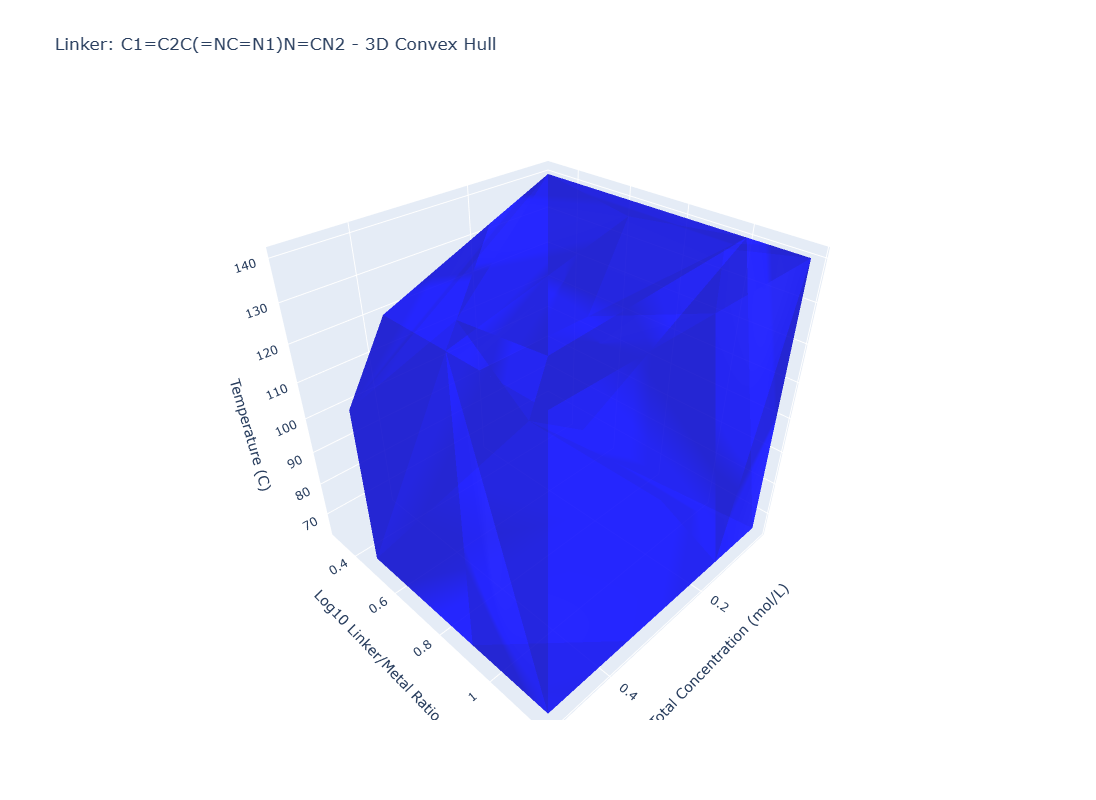

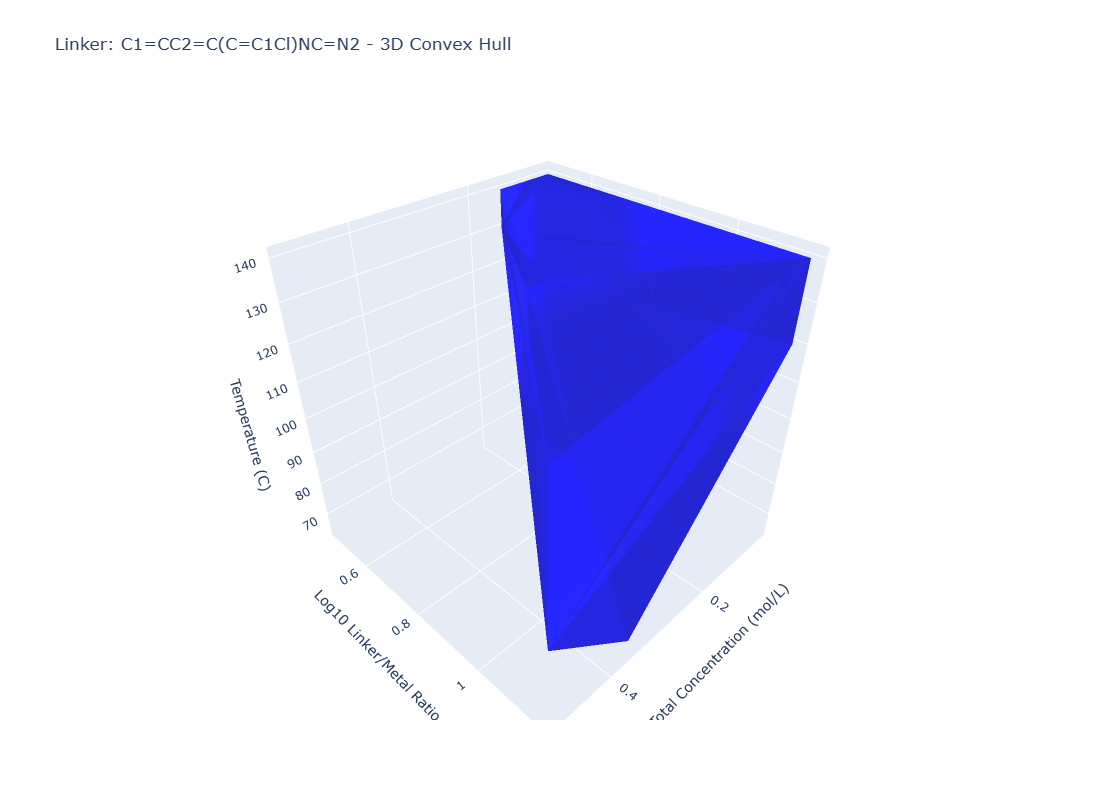

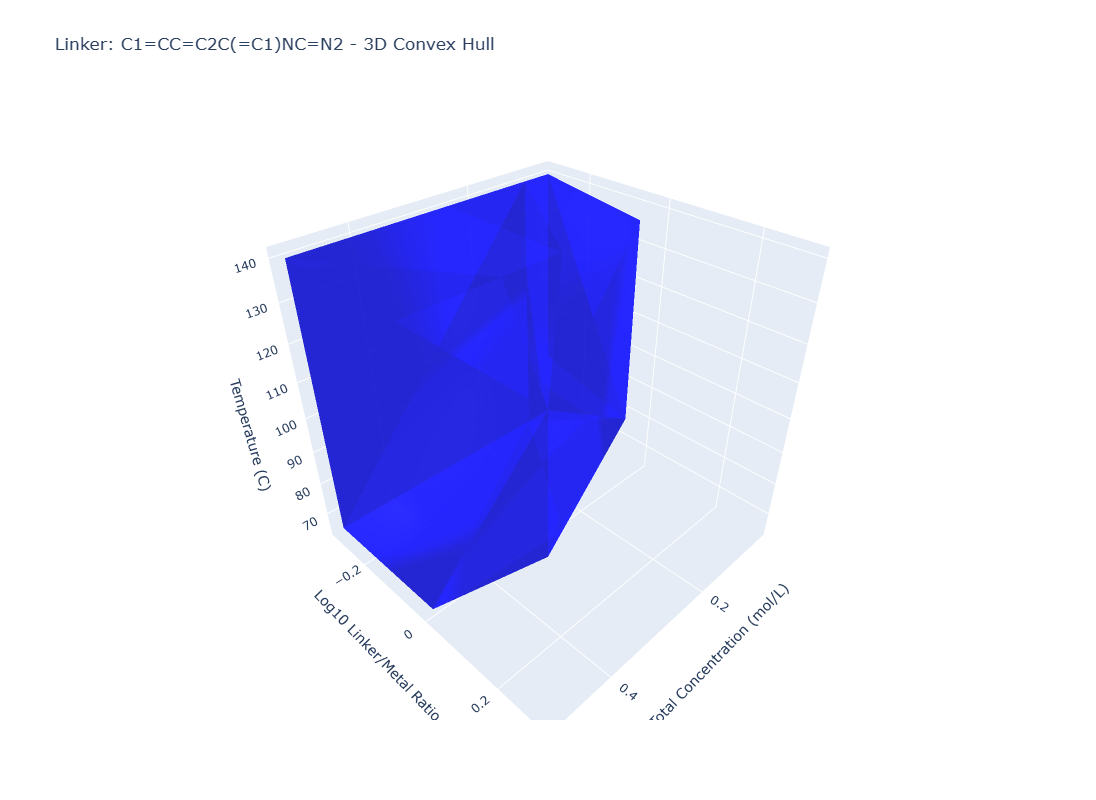

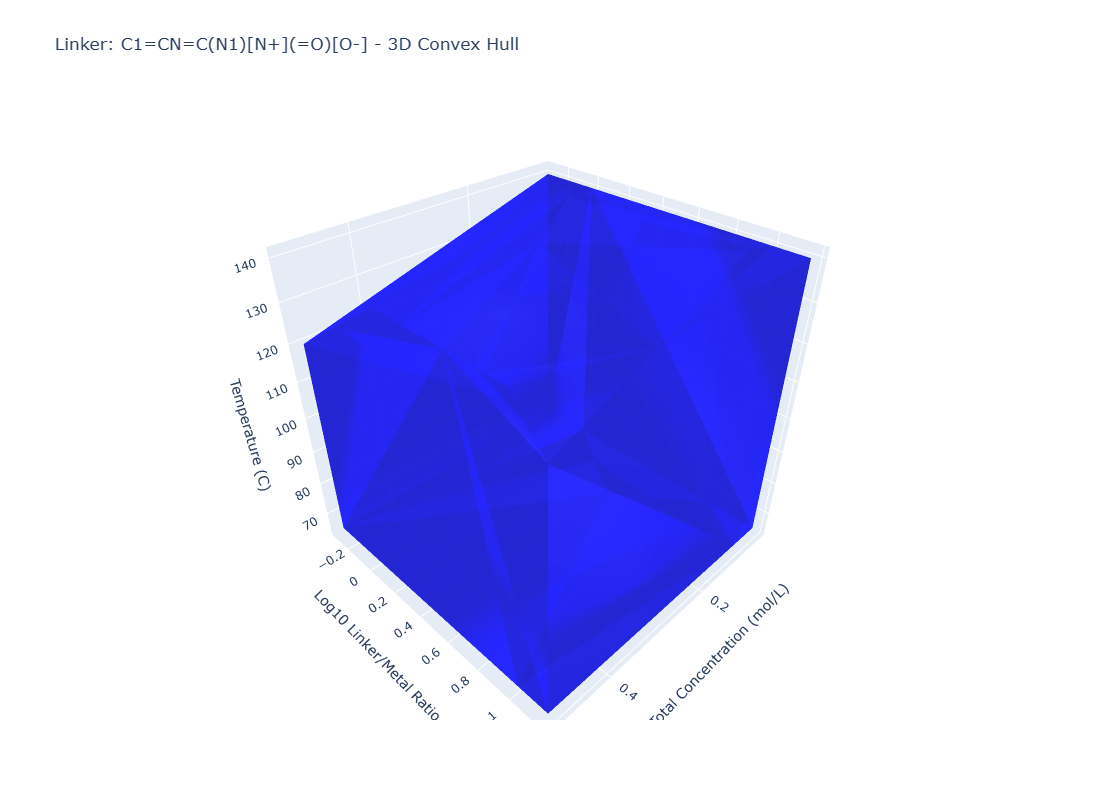

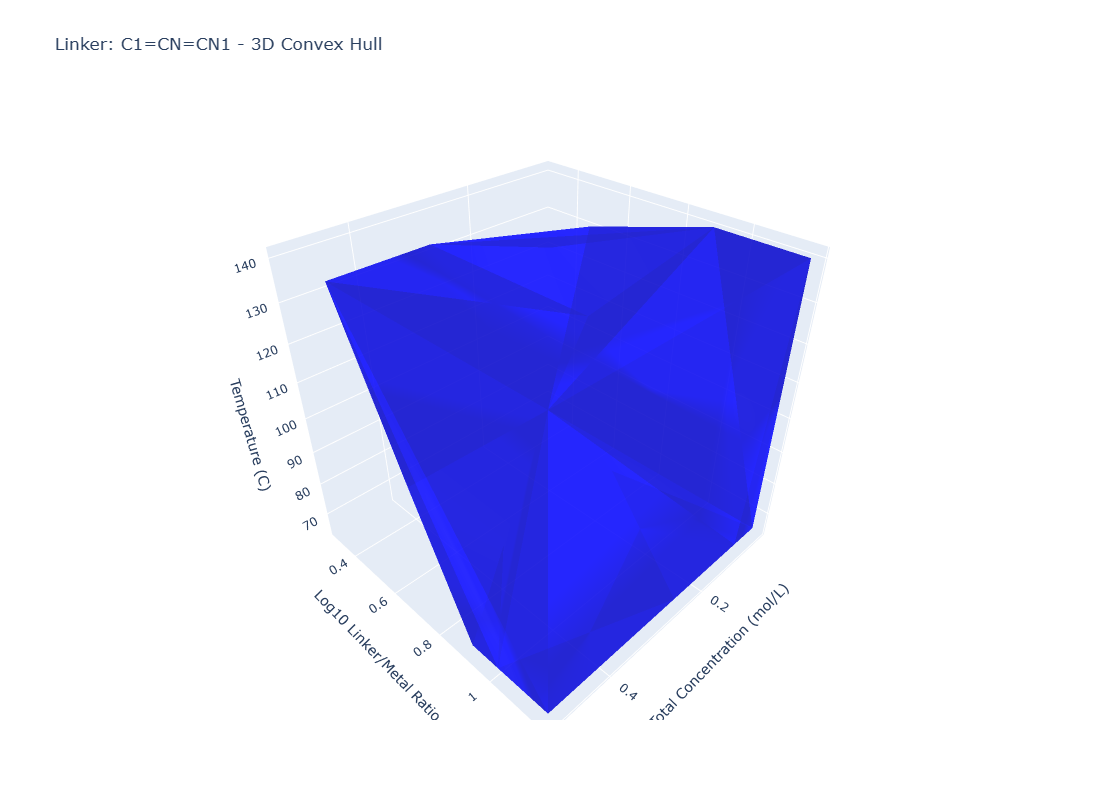

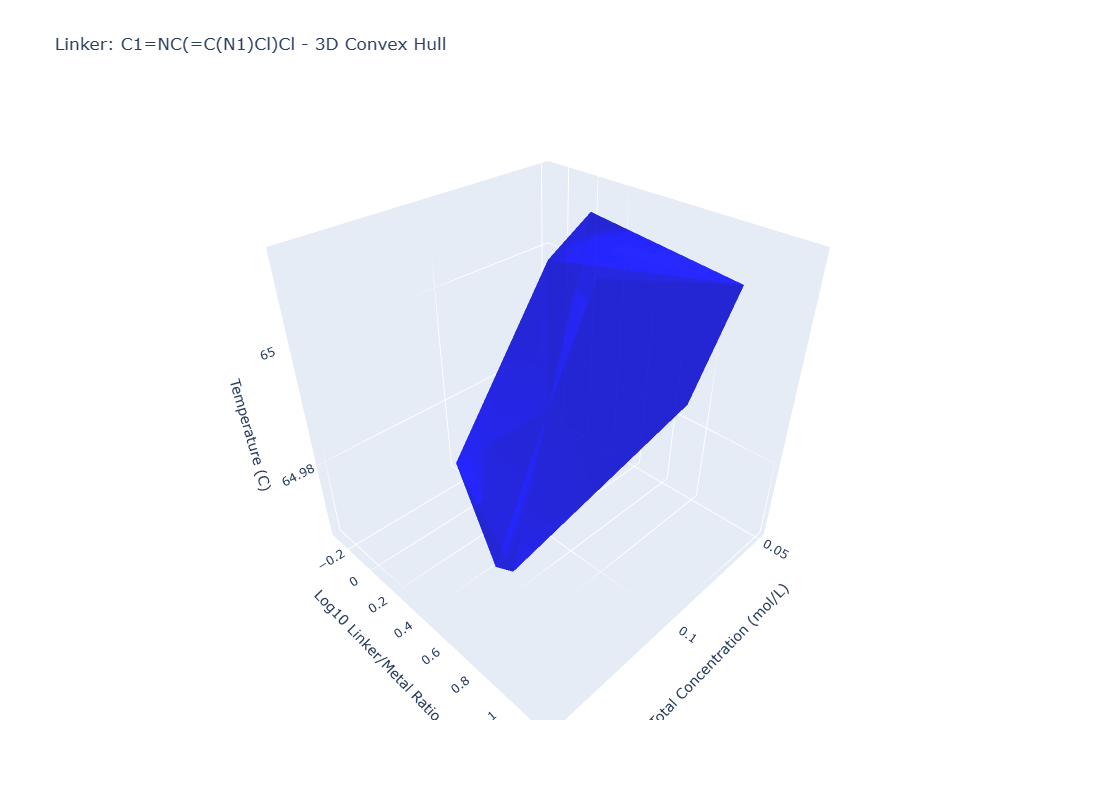

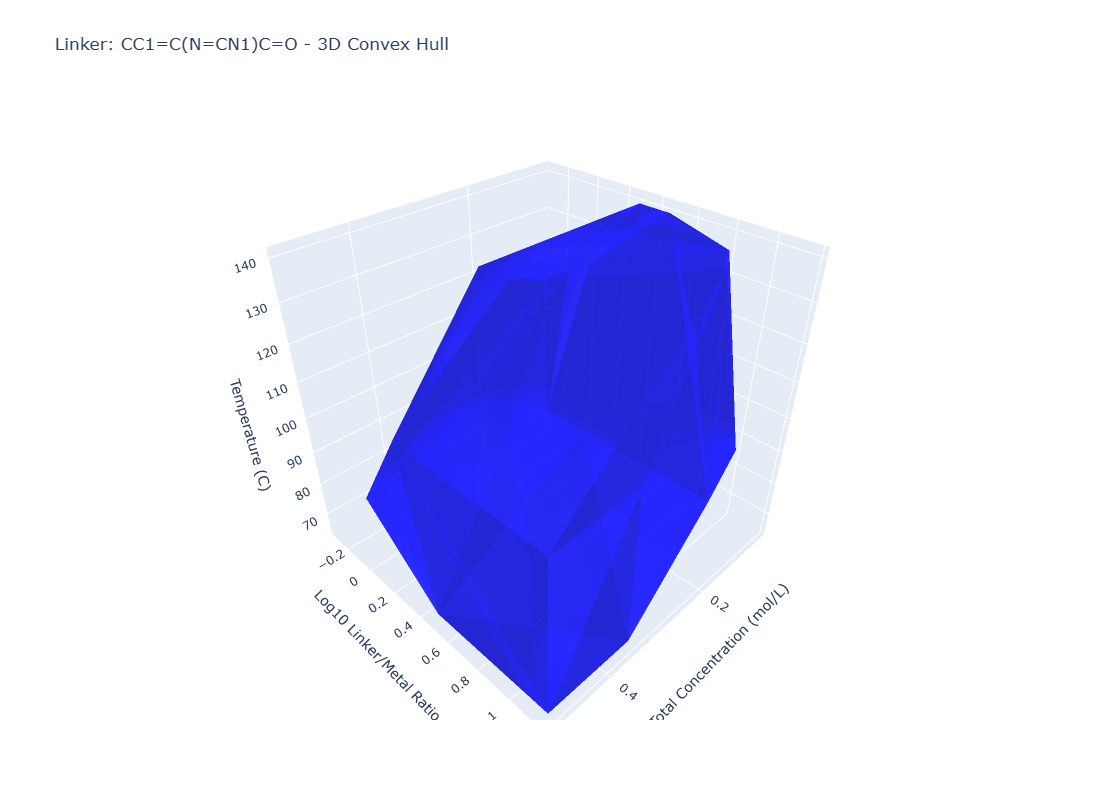

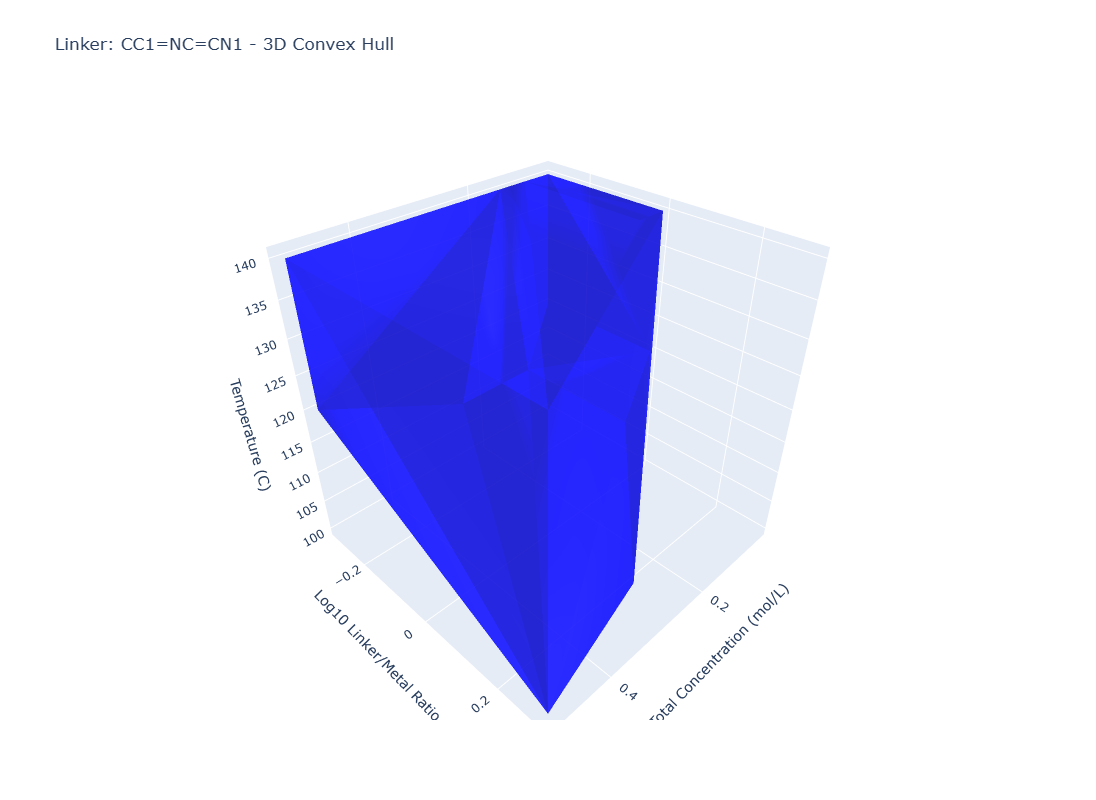

In [14]:
# Mine, 1st trial. Works perfectly

import numpy as np
import pandas as pd
from scipy.spatial import ConvexHull
import plotly.graph_objects as go

def plot_3d_convex_hull_plotly(df, linker_smiles):
    # Filter DataFrame for successful crystal outcomes and specific linker smiles
    df_filtered = df[(df['Crystal_clf'] == 1) & (df['LinkerCanonicalSmiles'] == linker_smiles)]

    # Check if there are enough points to create a convex hull
    if len(df_filtered) < 4:
        print(f"Not enough data points for linker {linker_smiles} to create a convex hull.")
        return

    # Extract points for the convex hull
    point_cloud = df_filtered[['rxn_TotalConcentration(mol/L)', 'rxn_Log10LinkerMetalRatio', 'rxn_Temperature(C)']].to_numpy()

    # Add a small random noise to the z-values (temperature) to avoid coplanarity
    point_cloud[:, 2] += np.random.normal(0, 0.01, size=point_cloud.shape[0])

    try:
        # Compute the convex hull
        hull = ConvexHull(point_cloud)

        # Create a 3D plot using Plotly
        x, y, z = point_cloud.T
        i, j, k = hull.simplices.T

        # Create a 3D convex hull plot
        fig = go.Figure(data=[
            go.Mesh3d(
                x=x,
                y=y,
                z=z,
                i=i,
                j=j,
                k=k,
                opacity=0.6,
                color='blue'
            )
        ])

        # Update layout to match your Delaunay triangulation plot
        fig.update_layout(
            scene=dict(
                xaxis_title='Total Concentration (mol/L)',
                yaxis_title='Log10 Linker/Metal Ratio',
                zaxis_title='Temperature (C)'
            ),
            width=900,
            height=800,
            title=f'Linker: {linker_smiles} - 3D Convex Hull'
        )

        fig.show()

    except Exception as e:
        print(f"Error in creating a convex hull for {linker_smiles}: {e}")
        return

# Load the dataset
file_path = r"C:\Users\iabdu\Downloads\ZIF_ML_Figures\8Kdataset_FinalizedFeatures.csv"
df = pd.read_csv(file_path)

# Iterate over each unique linker canonical smiles and plot
for linker_smiles in np.unique(df['LinkerCanonicalSmiles'].values):
    plot_3d_convex_hull_plotly(df, linker_smiles)


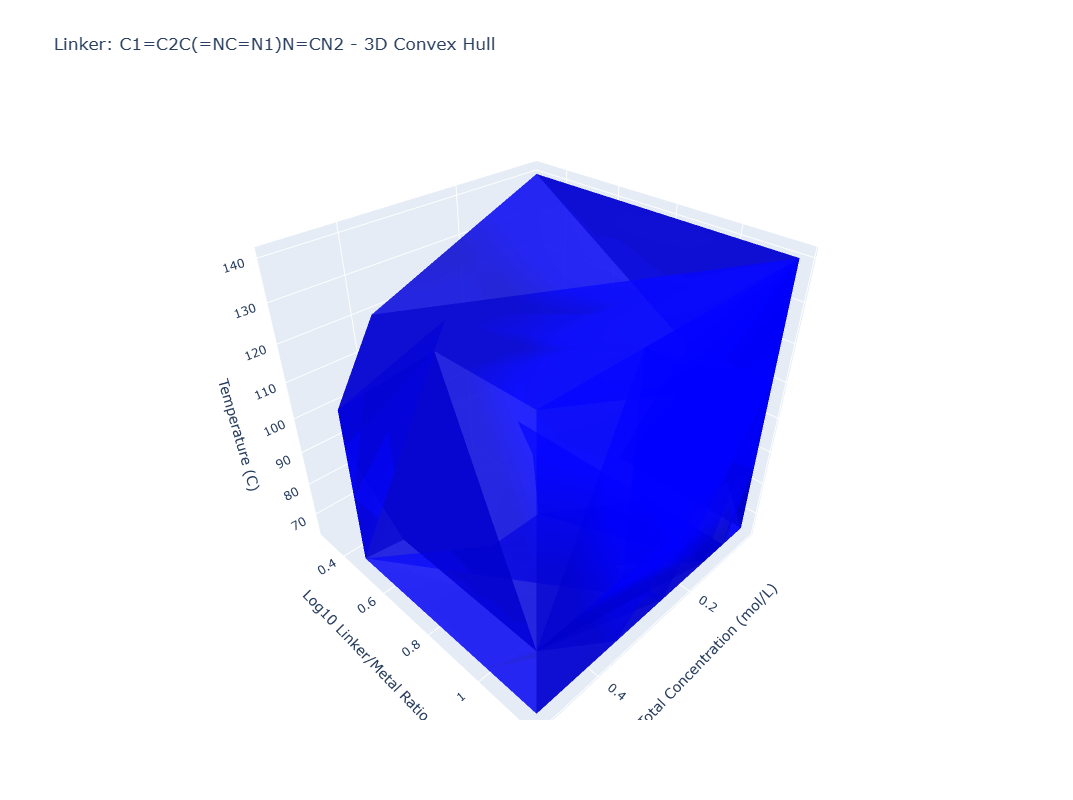

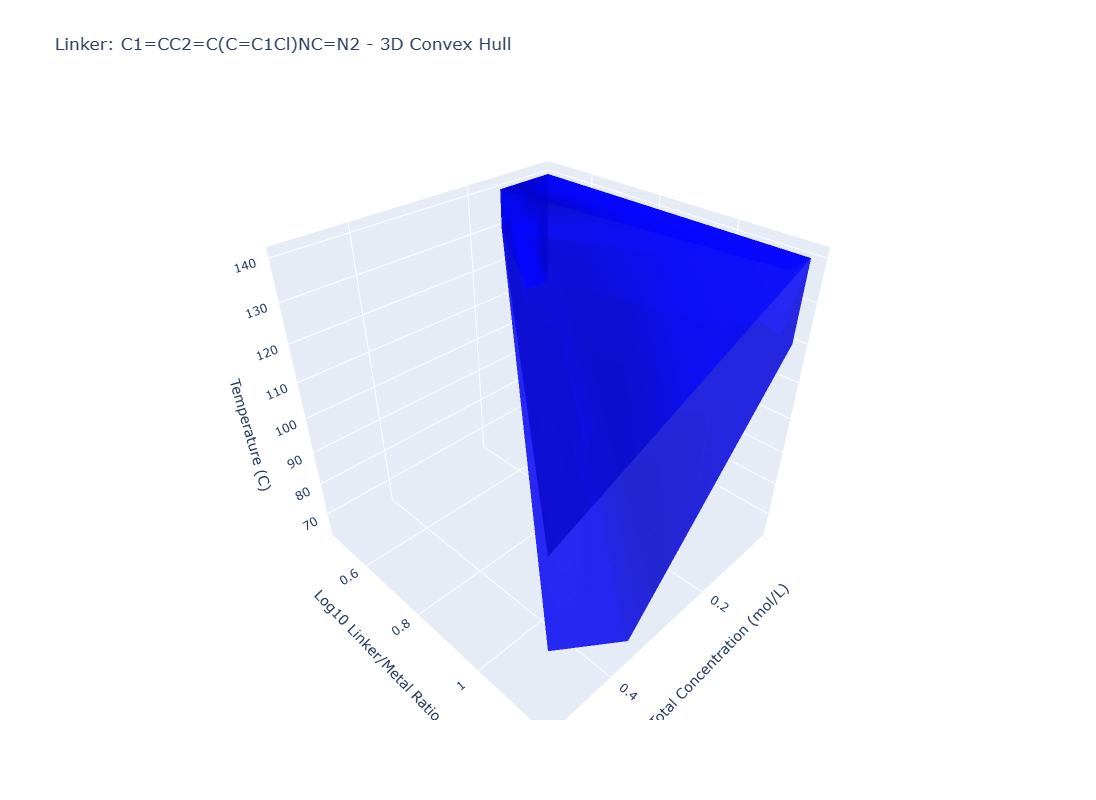

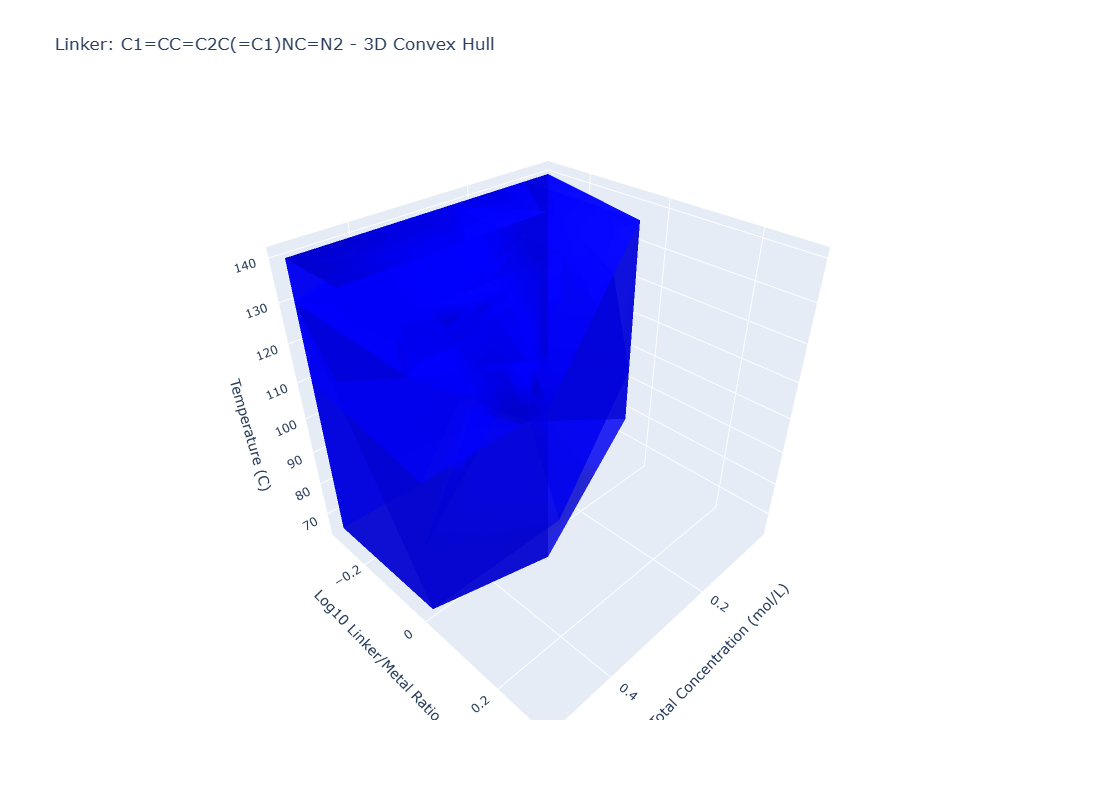

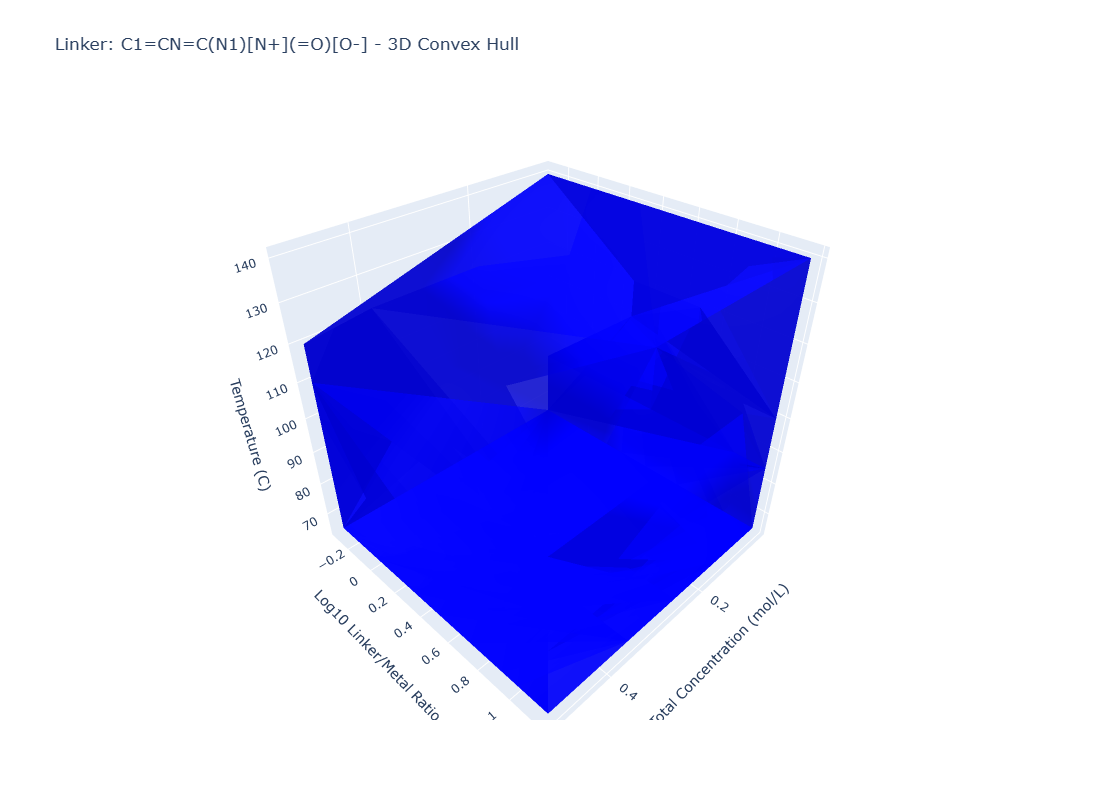

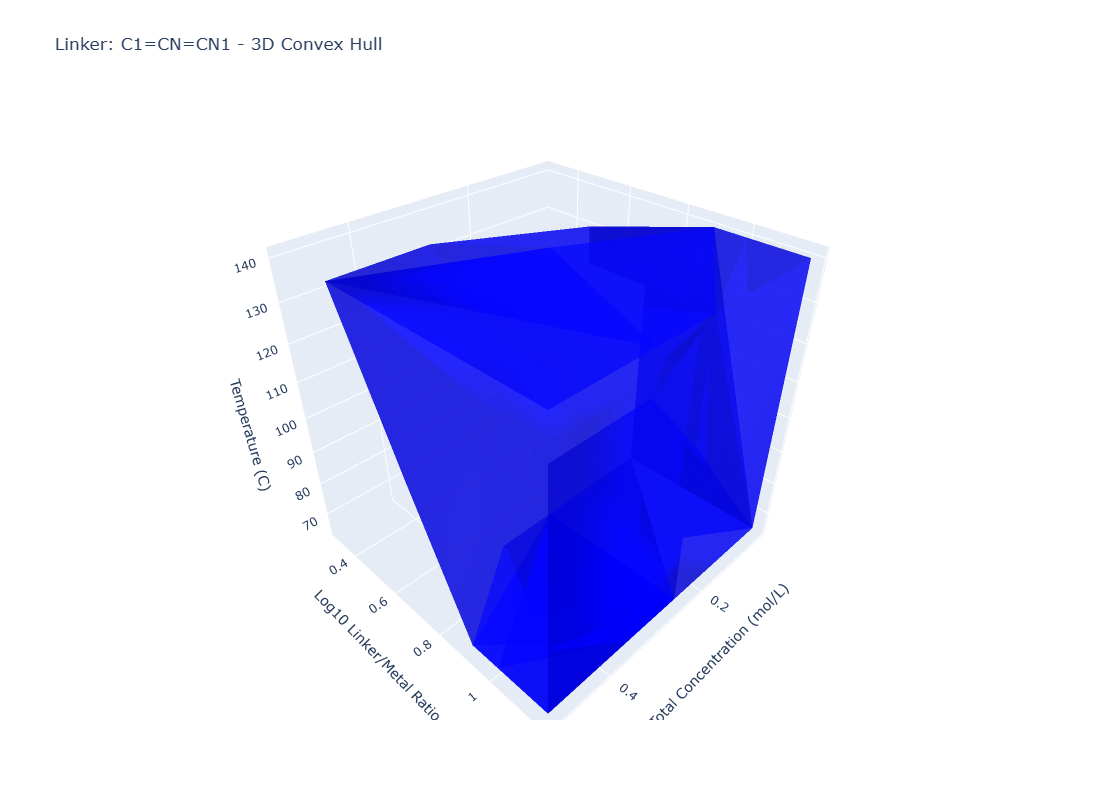

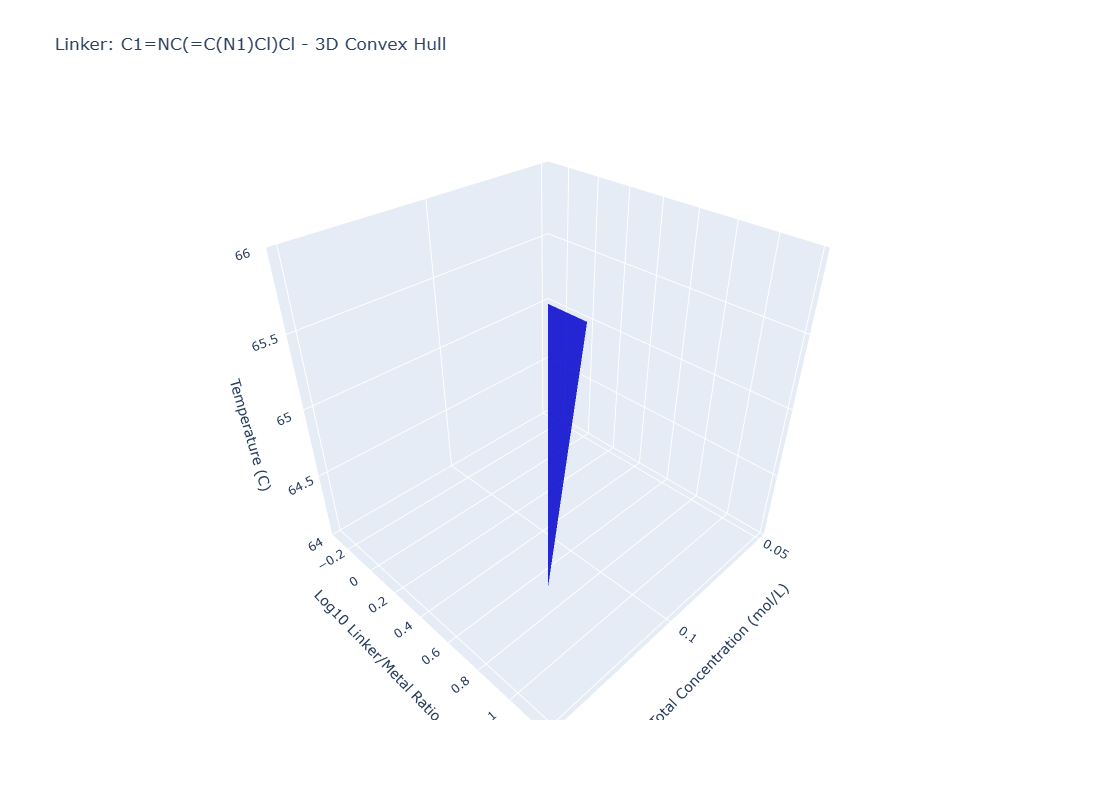

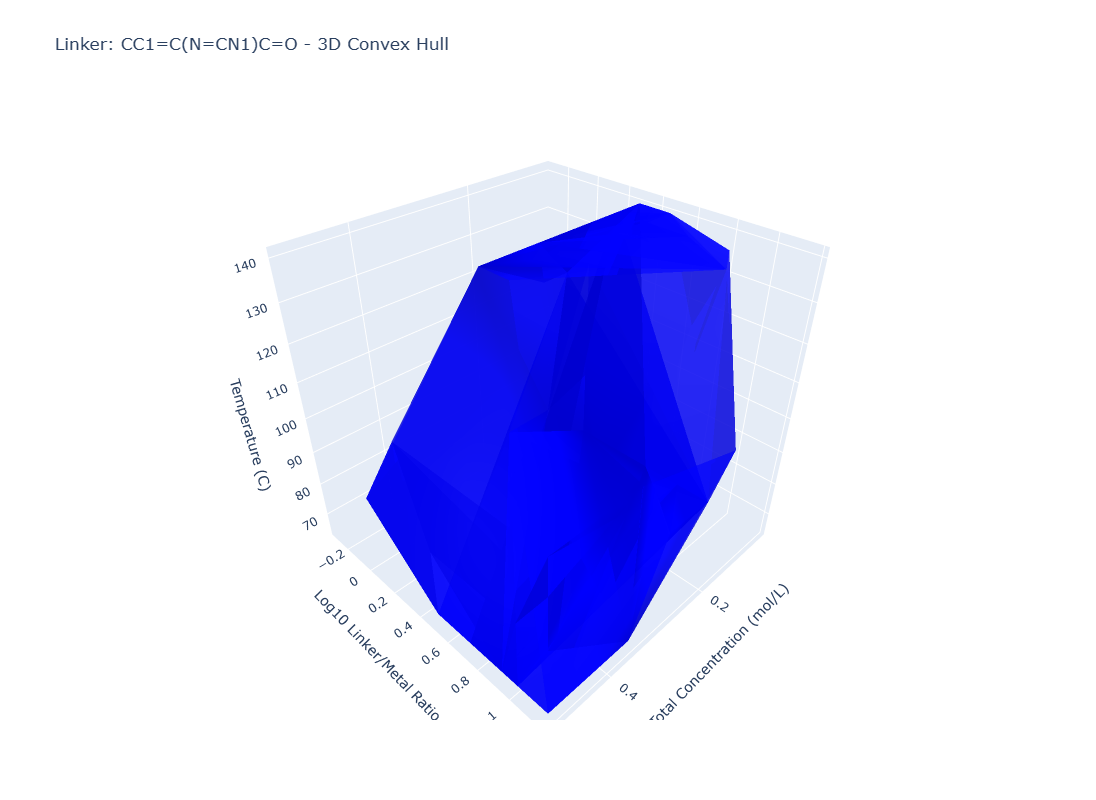

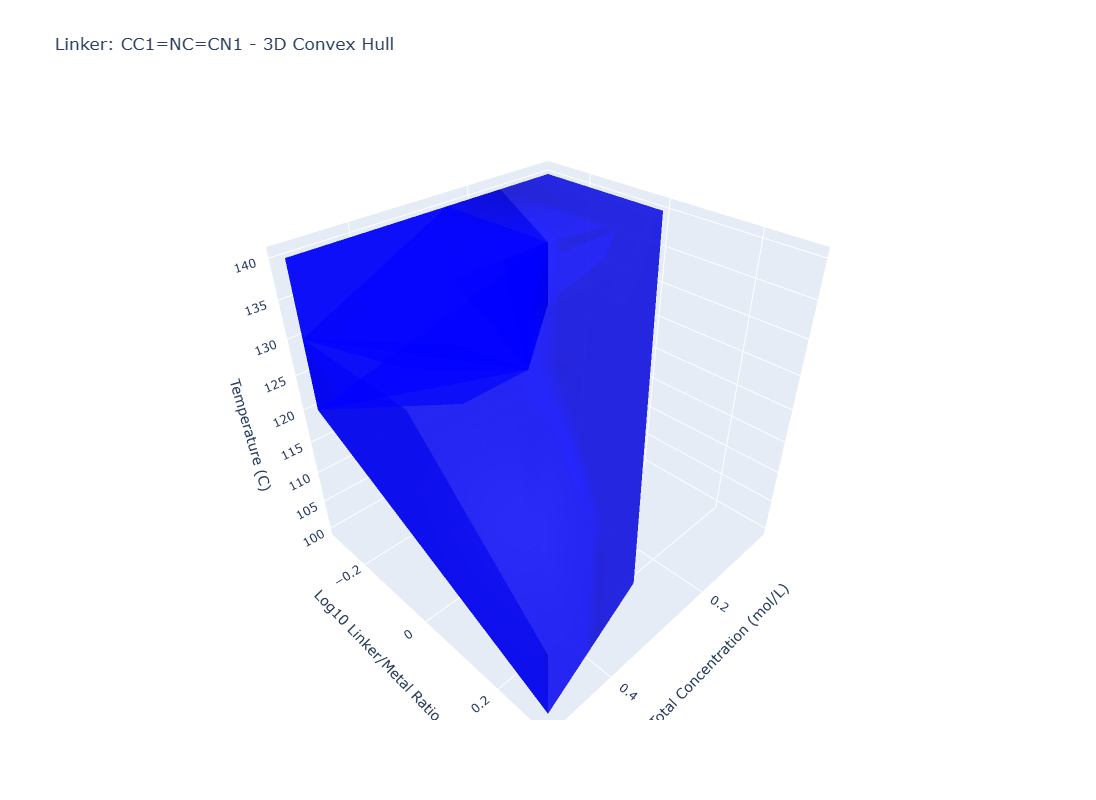

In [20]:
#Abdullah's 2nd try of convex hull -- this time using Gift Wrapping Algorithm
#Best So far


import pandas as pd
import numpy as np
import plotly.graph_objects as go
from convex_hull import gift_wrapping, Point  # Import the gift_wrapping function and Point class

def plot_3d_convex_hull_plotly(point_cloud, hull_faces, title):
    # Convert the points into the format required by Plotly
    x, y, z = zip(*[(p.x, p.y, p.z) for p in point_cloud])

    # Extract indices for the faces from the hull
    i, j, k = [], [], []
    for face in hull_faces:
        i.append(point_cloud.index(face.points[0]))
        j.append(point_cloud.index(face.points[1]))
        k.append(point_cloud.index(face.points[2]))

    # Create a 3D convex hull plot
    fig = go.Figure(data=[go.Mesh3d(x=x, y=y, z=z, i=i, j=j, k=k, opacity=0.6, color='blue')])
    fig.update_layout(scene=dict(xaxis_title='Total Concentration (mol/L)', yaxis_title='Log10 Linker/Metal Ratio', zaxis_title='Temperature (C)'), width=900, height=800, title=title)
    fig.show()

# Load the dataset
file_path = r"C:\Users\iabdu\Downloads\ZIF_ML_Figures\8Kdataset_FinalizedFeatures.csv"
df = pd.read_csv(file_path)

# Iterate over each unique linker canonical smiles and plot
for linker_smiles in np.unique(df['LinkerCanonicalSmiles'].values):
    # Filter and extract the points
    df_filtered = df[(df['Crystal_clf'] == 1) & (df['LinkerCanonicalSmiles'] == linker_smiles)]
    if len(df_filtered) < 4:
        continue  # Skip if not enough points

    # Create Point objects from the filtered dataset
    point_cloud = [Point(row[0], row[1], row[2]) for row in df_filtered[['rxn_TotalConcentration(mol/L)', 'rxn_Log10LinkerMetalRatio', 'rxn_Temperature(C)']].values]

    # Compute the convex hull using the gift wrapping algorithm
    hull_faces = gift_wrapping(point_cloud)

    # Plot the 3D convex hull
    plot_3d_convex_hull_plotly(point_cloud, hull_faces, f'Linker: {linker_smiles} - 3D Convex Hull')


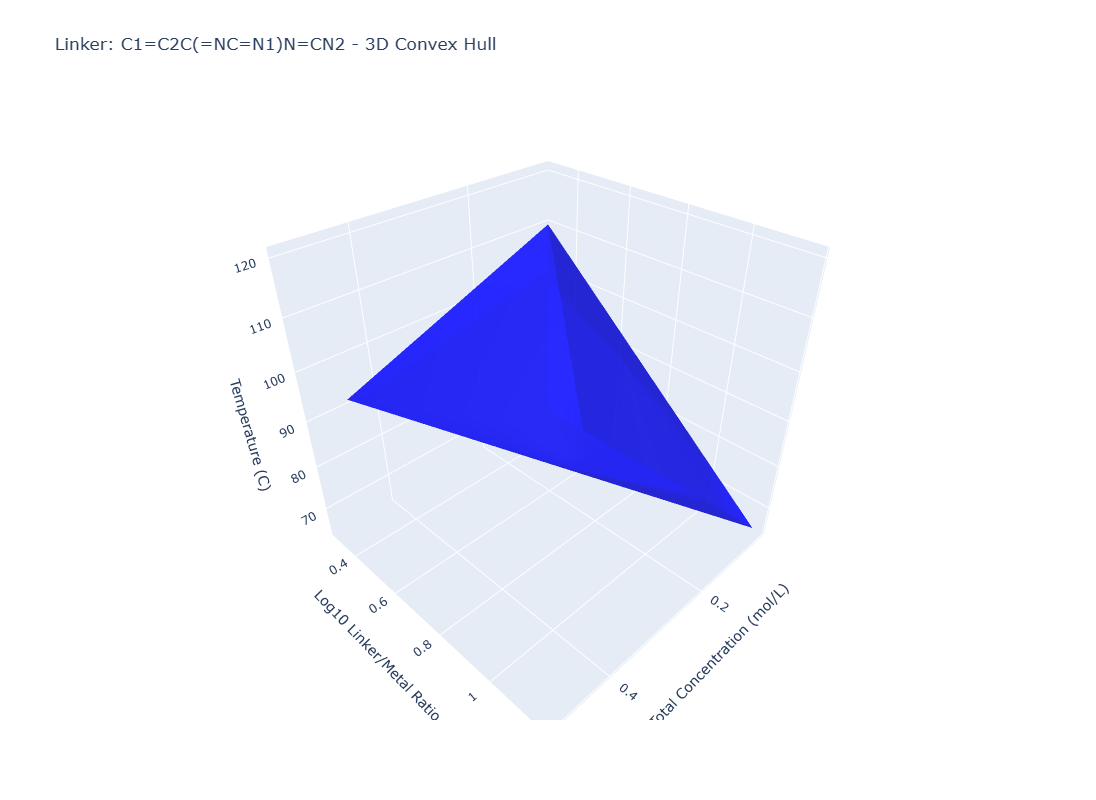

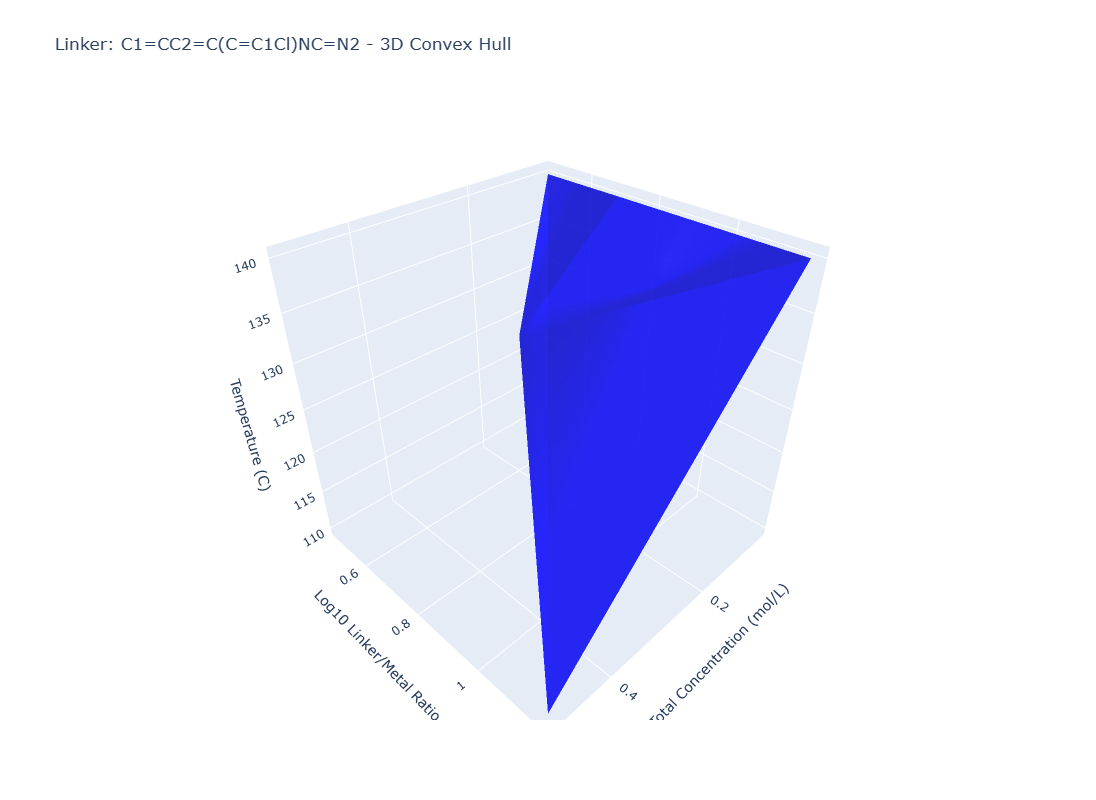

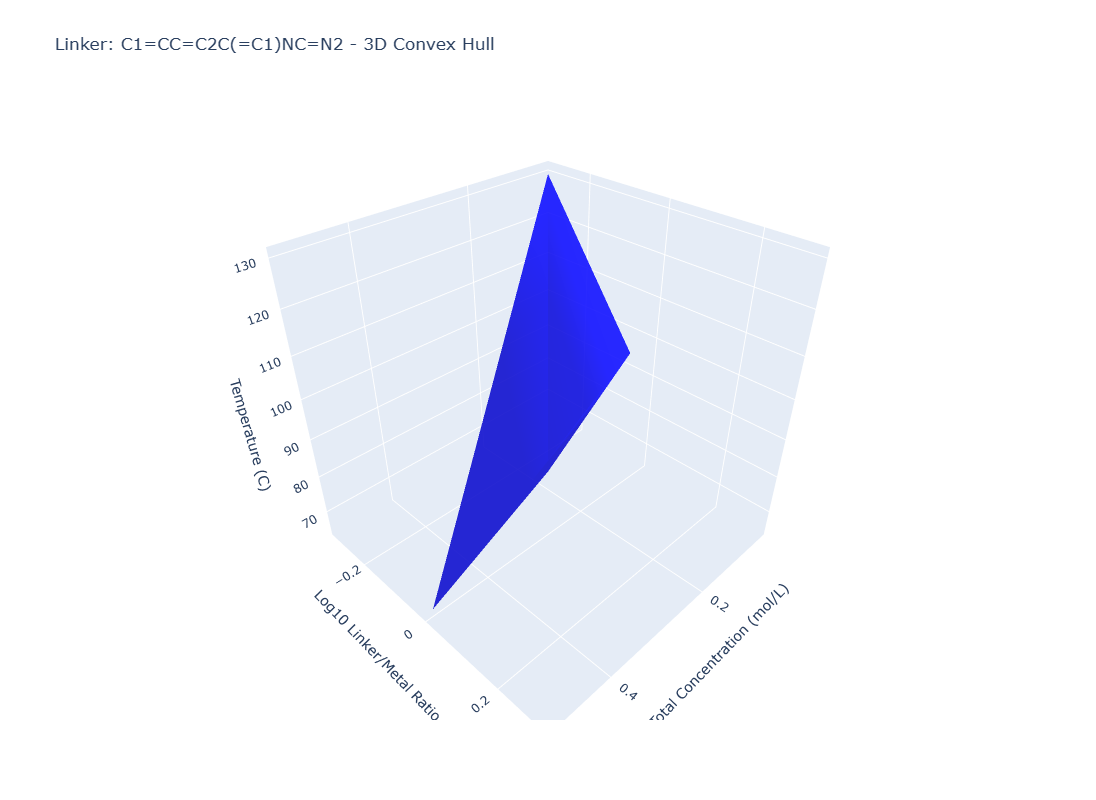

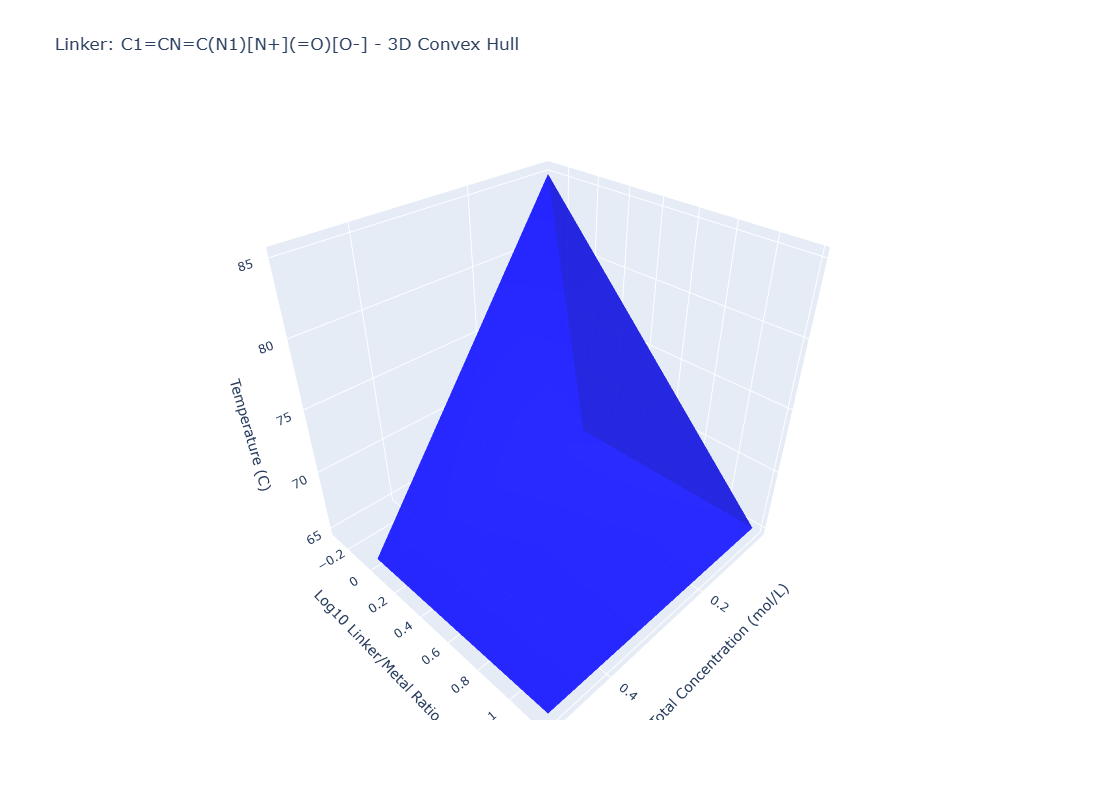

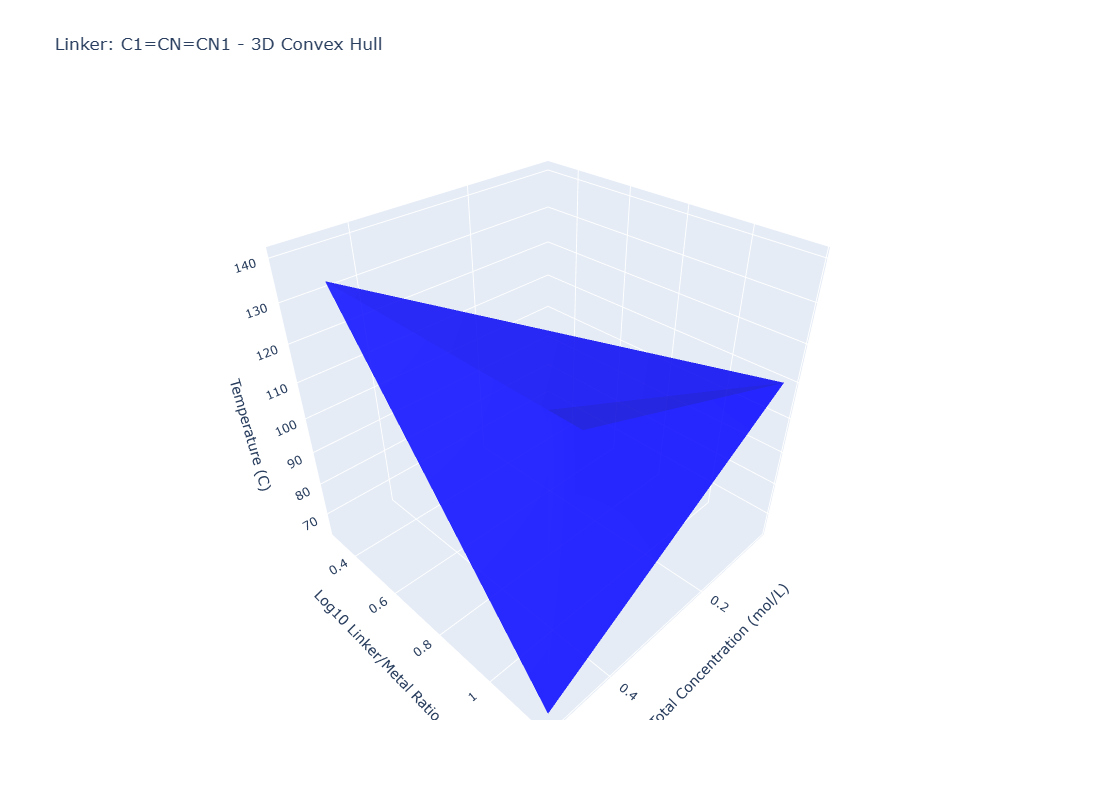

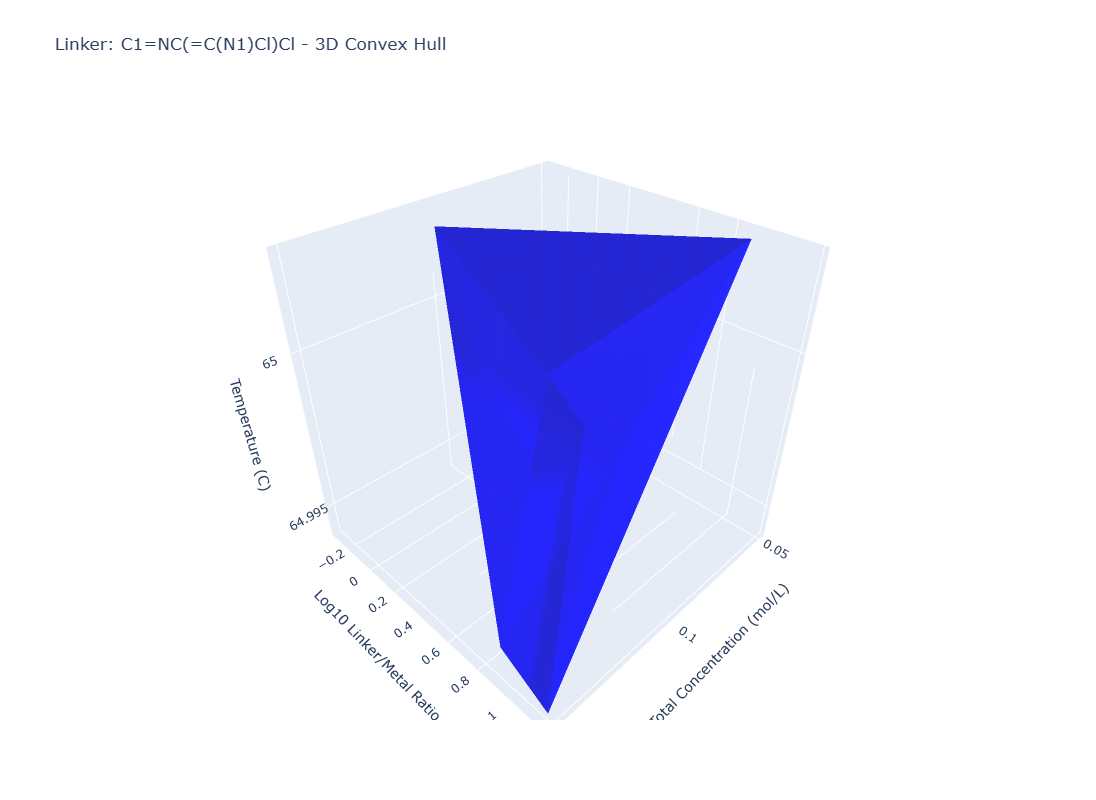

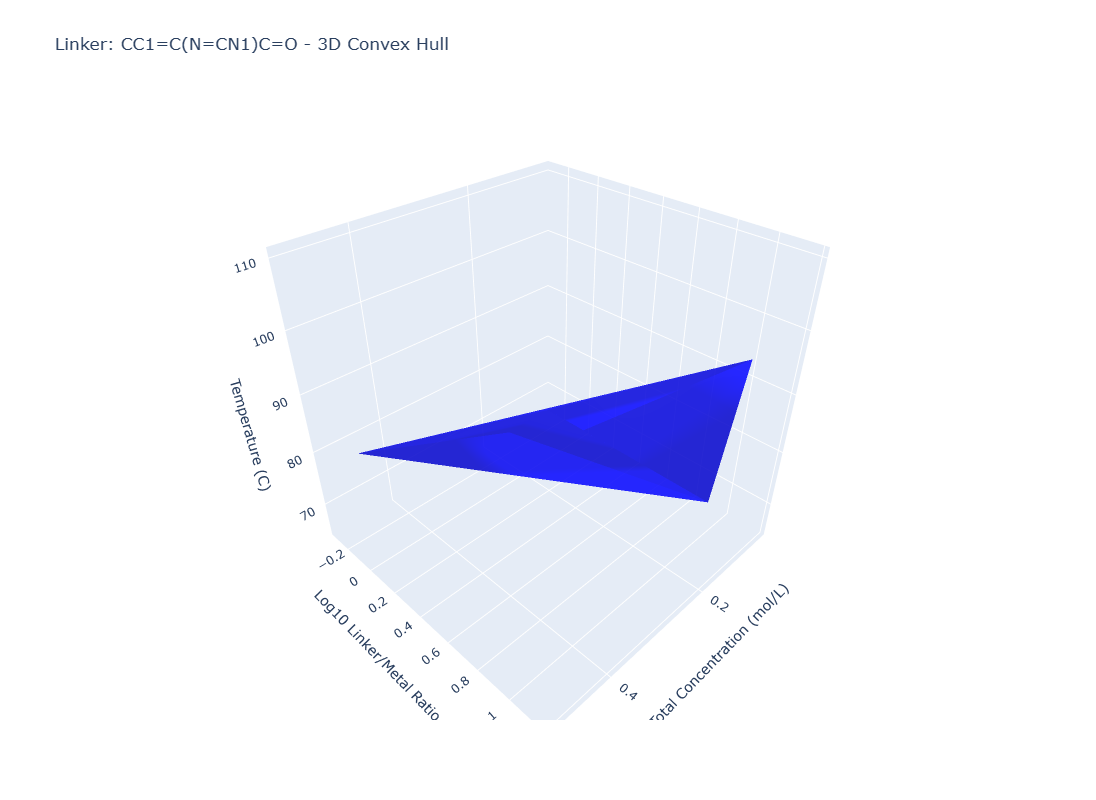

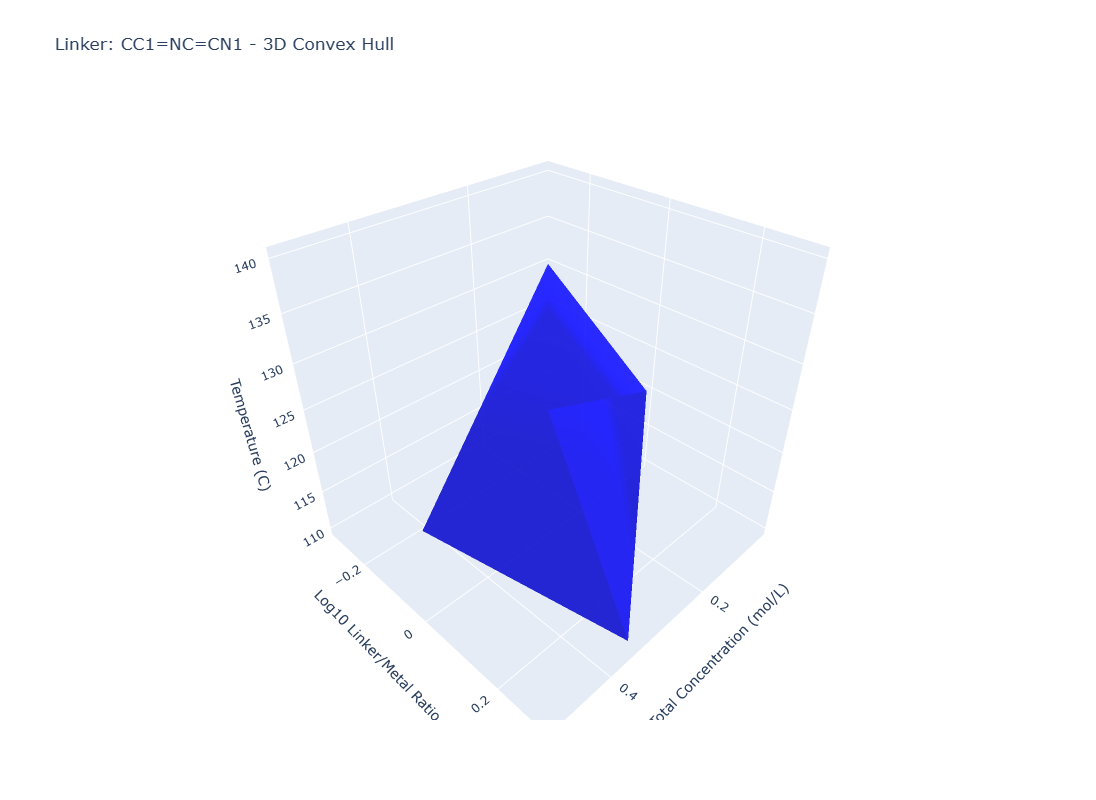

In [16]:
#Now this one also works perfectly 

import pandas as pd
import numpy as np
import plotly.graph_objects as go
from scipy.spatial import ConvexHull, QhullError

def graham_scan(points):
    """ Perform the Graham scan on a set of points. """
    def angle(p1, p2):
        return np.arctan2(p2[1] - p1[1], p2[0] - p1[0])

    def distance(p1, p2):
        return np.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)

    def is_counter_clockwise(p1, p2, p3):
        return (p2[0] - p1[0]) * (p3[1] - p1[1]) > (p2[1] - p1[1]) * (p3[0] - p1[0])

    # Find the lowest y-coordinate and leftmost point
    start = min(points, key=lambda p: (p[1], p[0]))
    points.pop(points.index(start))

    # Sort points by polar angle with start point
    points.sort(key=lambda p: (angle(start, p), -distance(start, p)))

    # Initialize the convex hull with the start point
    hull = [start]

    for point in points:
        while len(hull) > 1 and not is_counter_clockwise(hull[-2], hull[-1], point):
            hull.pop()
        hull.append(point)

    return hull

def plot_3d_convex_hull_plotly(df, linker_smiles):
    # Filter DataFrame for successful crystal outcomes and specific linker smiles
    df_filtered = df[(df['Crystal_clf'] == 1) & (df['LinkerCanonicalSmiles'] == linker_smiles)]

    # Check if there are enough points to create a convex hull
    if len(df_filtered) < 4:
        print(f"Not enough data points for linker {linker_smiles} to create a convex hull.")
        return

    # Extract points for the convex hull
    point_cloud = df_filtered[['rxn_TotalConcentration(mol/L)', 'rxn_Log10LinkerMetalRatio', 'rxn_Temperature(C)']].to_numpy()

    # Add a small random noise to the z-values (temperature) to avoid coplanarity
    point_cloud[:, 2] += np.random.normal(0, 0.01, size=point_cloud.shape[0])

    try:
        # Perform Graham scan on the point cloud
        hull_points = graham_scan(point_cloud.tolist())
        hull = ConvexHull(np.array(hull_points))

        # Create a 3D plot using Plotly
        x, y, z = np.array(hull_points).T
        i, j, k = hull.simplices.T

        # Create a 3D convex hull plot
        fig = go.Figure(data=[
            go.Mesh3d(
                x=x,
                y=y,
                z=z,
                i=i,
                j=j,
                k=k,
                opacity=0.6,
                color='blue'
            )
        ])

        # Update layout
        fig.update_layout(
            scene=dict(
                xaxis_title='Total Concentration (mol/L)',
                yaxis_title='Log10 Linker/Metal Ratio',
                zaxis_title='Temperature (C)'
            ),
            width=900,
            height=800,
            title=f'Linker: {linker_smiles} - 3D Convex Hull'
        )

        fig.show()

    except QhullError as e:
        print(f"Cannot create a convex hull for {linker_smiles}. Reason: {e}")
        return

# Load the dataset
file_path = r"C:\Users\iabdu\Downloads\ZIF_ML_Figures\8Kdataset_FinalizedFeatures.csv"
df = pd.read_csv(file_path)

# Iterate over each unique linker canonical smiles and plot
for linker_smiles in np.unique(df['LinkerCanonicalSmiles'].values):
    plot_3d_convex_hull_plotly(df, linker_smiles)


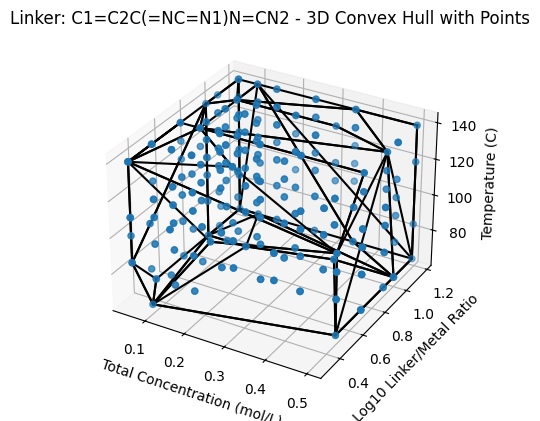

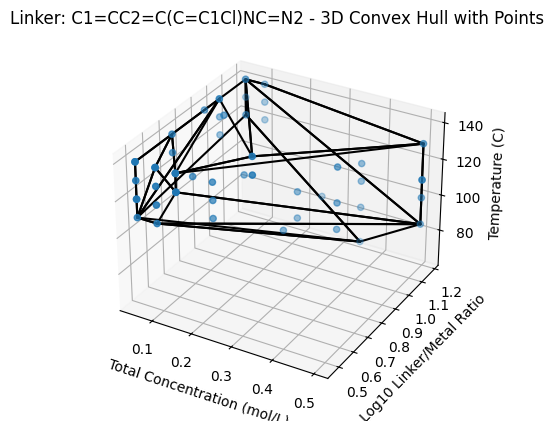

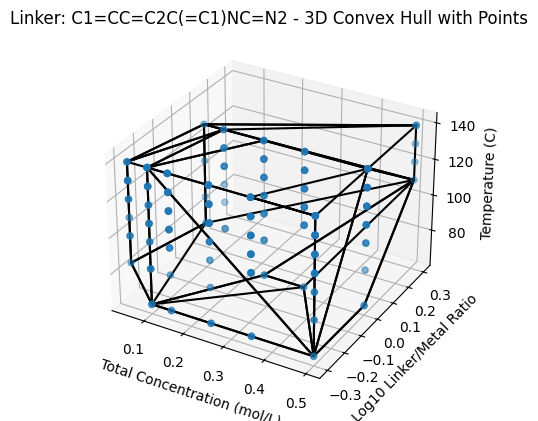

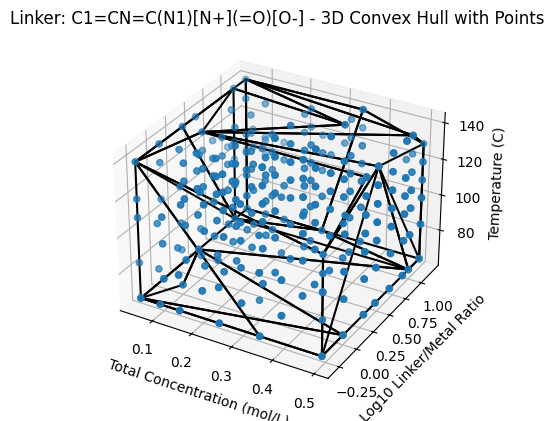

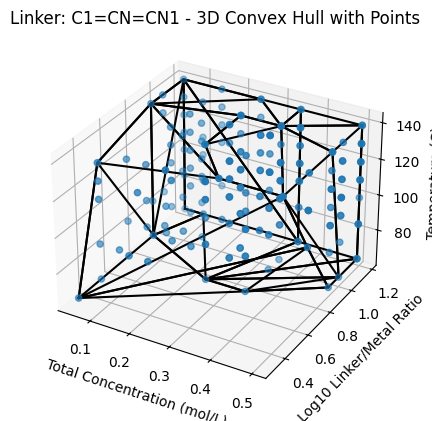

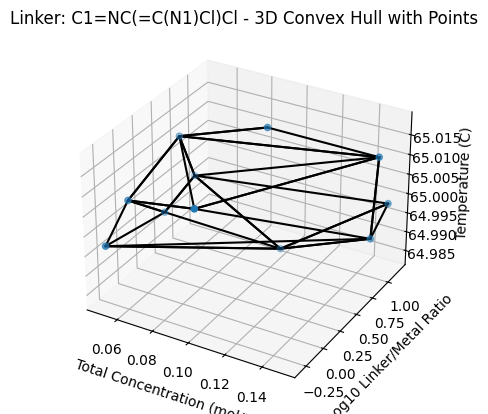

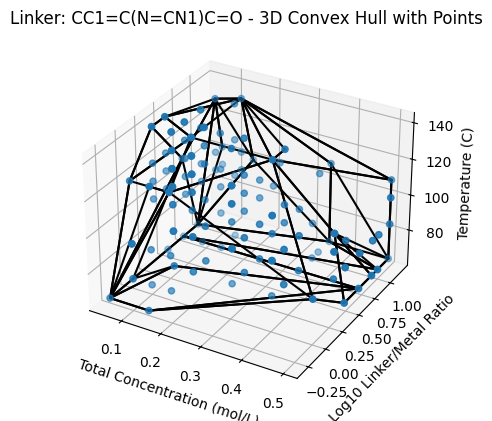

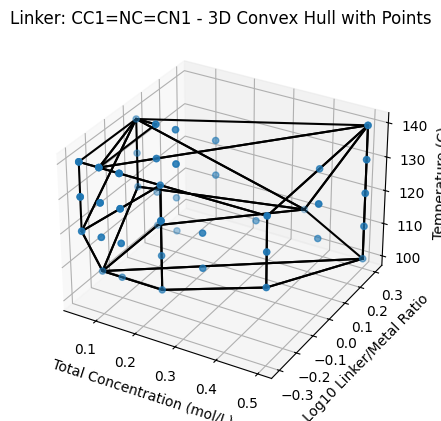

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull

def plot_3d_convex_hull_matplotlib(df, linker_smiles):
    # Filter DataFrame for successful crystal outcomes and specific linker smiles
    df_filtered = df[(df['Crystal_clf'] == 1) & (df['LinkerCanonicalSmiles'] == linker_smiles)]

    # Check if there are enough points to create a convex hull
    if len(df_filtered) < 4:
        print(f"Not enough data points for linker {linker_smiles} to create a convex hull.")
        return

    # Extract points for the convex hull
    point_cloud = df_filtered[['rxn_TotalConcentration(mol/L)', 'rxn_Log10LinkerMetalRatio', 'rxn_Temperature(C)']].to_numpy()

    # Add a small random noise to the z-values (temperature) to avoid coplanarity
    point_cloud[:, 2] += np.random.normal(0, 0.01, size=point_cloud.shape[0])

    try:
        hull = ConvexHull(point_cloud)

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        # Scatter plot for points
        ax.scatter(point_cloud[:,0], point_cloud[:,1], point_cloud[:,2])

        # Plotting the convex hull
        for simplex in hull.simplices:
            plt.plot(point_cloud[simplex, 0], point_cloud[simplex, 1], point_cloud[simplex, 2], 'k-')

        # Setting labels
        ax.set_xlabel('Total Concentration (mol/L)')
        ax.set_ylabel('Log10 Linker/Metal Ratio')
        ax.set_zlabel('Temperature (C)')

        plt.title(f'Linker: {linker_smiles} - 3D Convex Hull with Points')
        plt.show()

    except Exception as e:
        print(f"Error in creating a convex hull for {linker_smiles}. Reason: {e}")
        return

# Load the dataset
file_path = r"C:\Users\iabdu\Downloads\ZIF_ML_Figures\8Kdataset_FinalizedFeatures.csv"
df = pd.read_csv(file_path)

# Iterate over each unique linker canonical smiles and plot
for linker_smiles in np.unique(df['LinkerCanonicalSmiles'].values):
    plot_3d_convex_hull_matplotlib(df, linker_smiles)


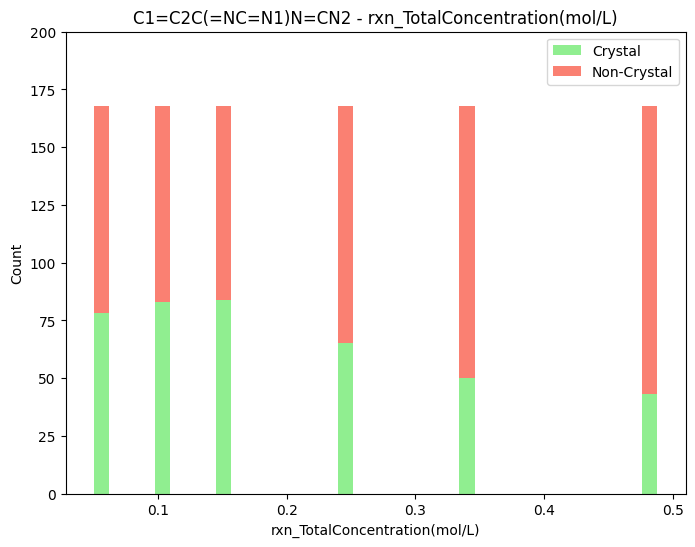

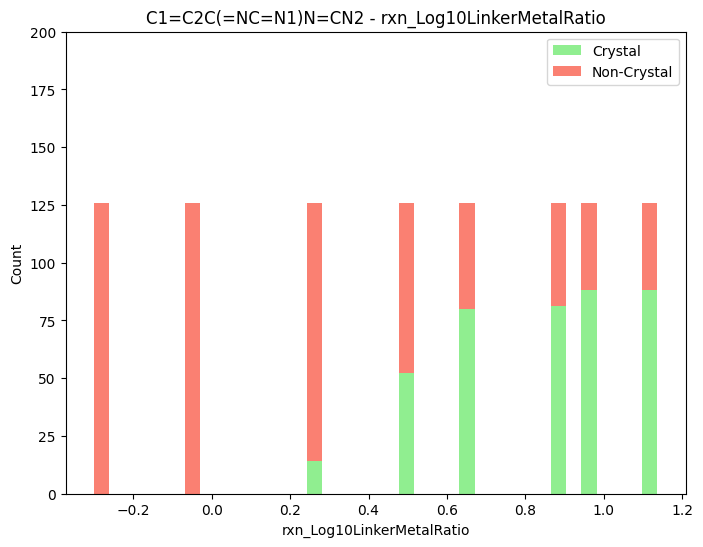

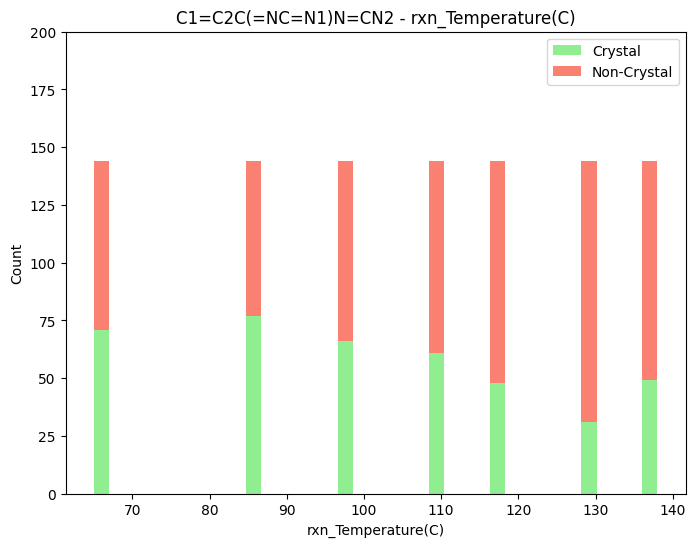

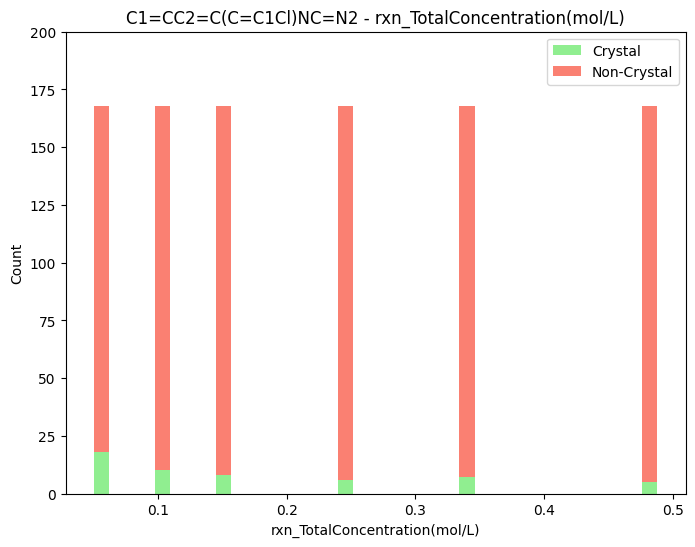

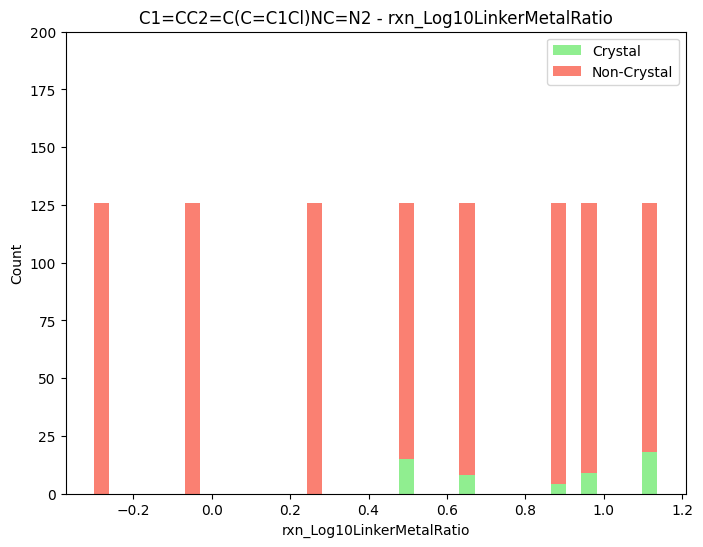

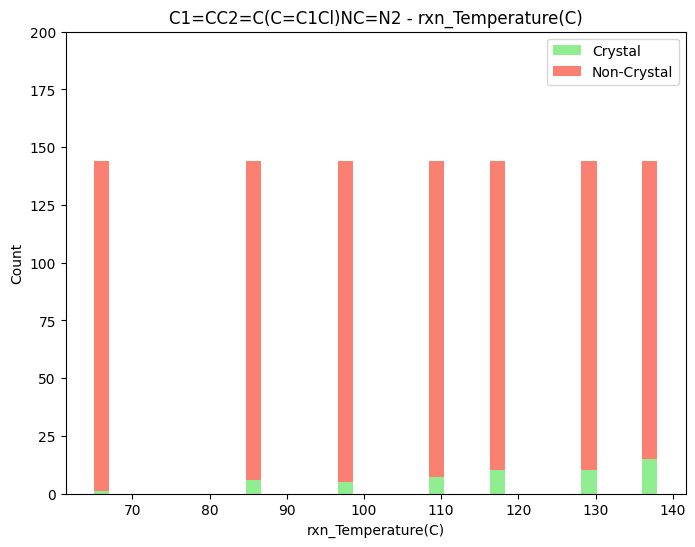

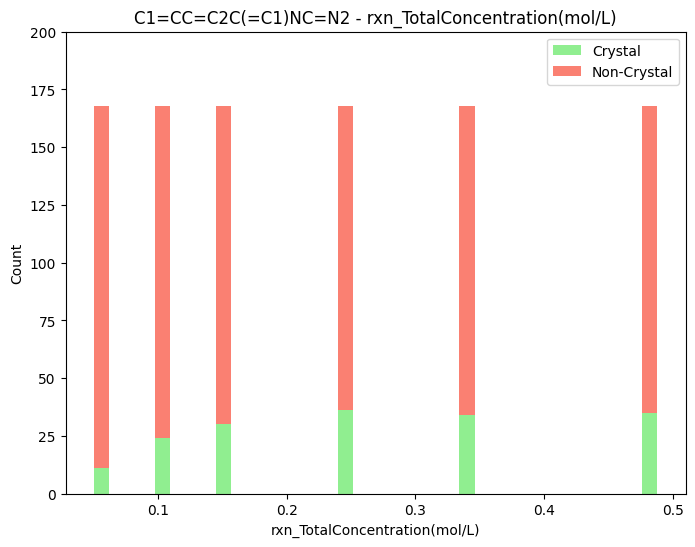

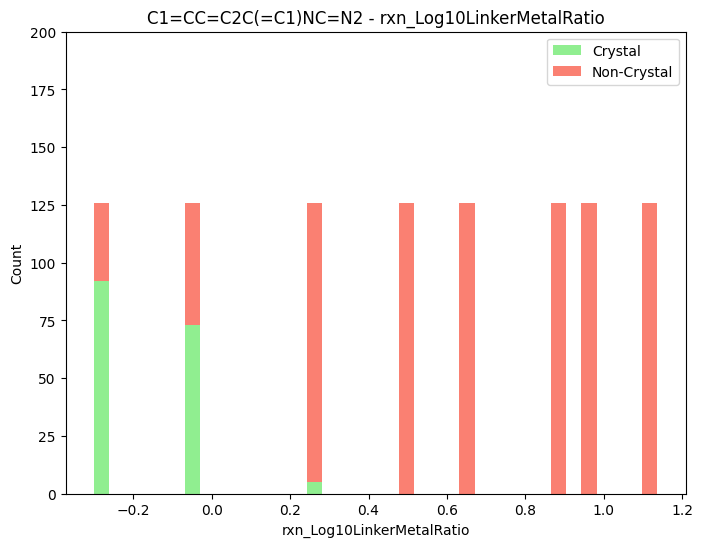

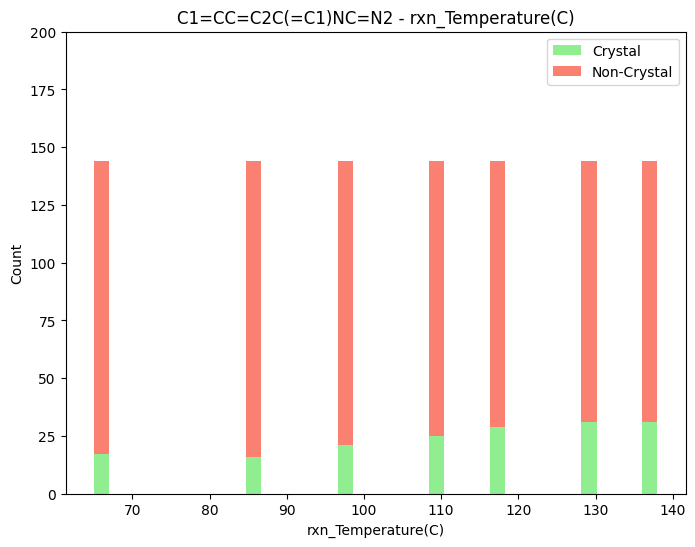

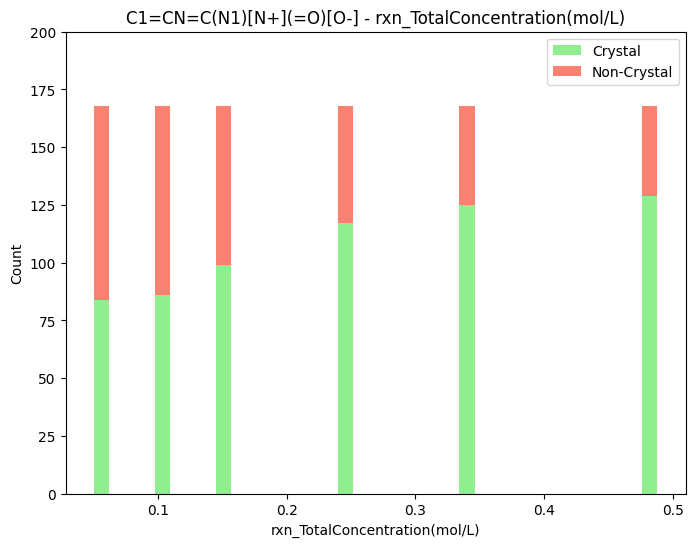

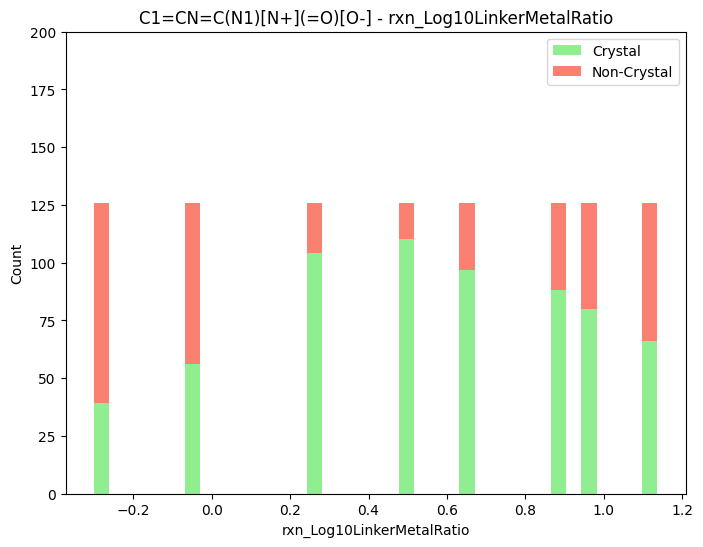

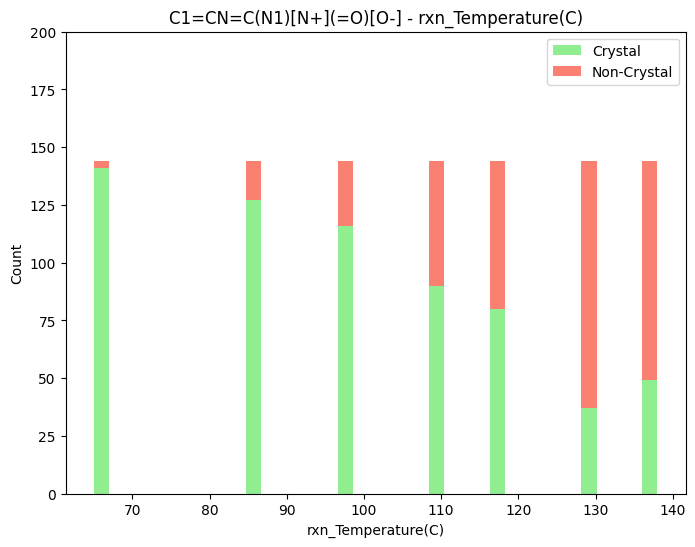

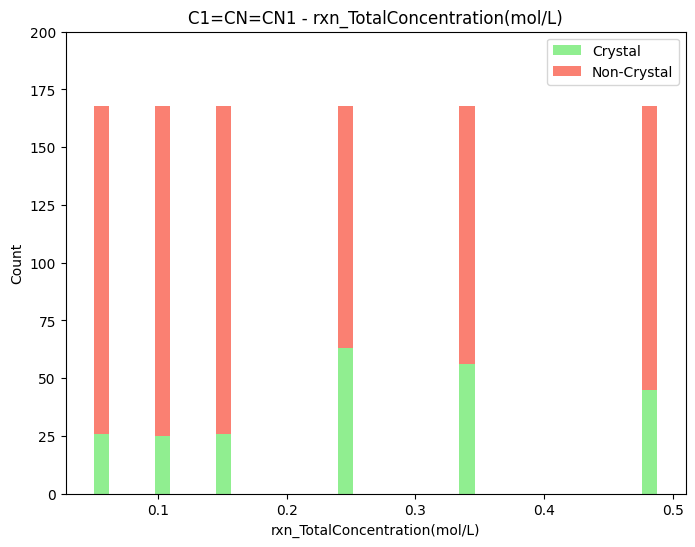

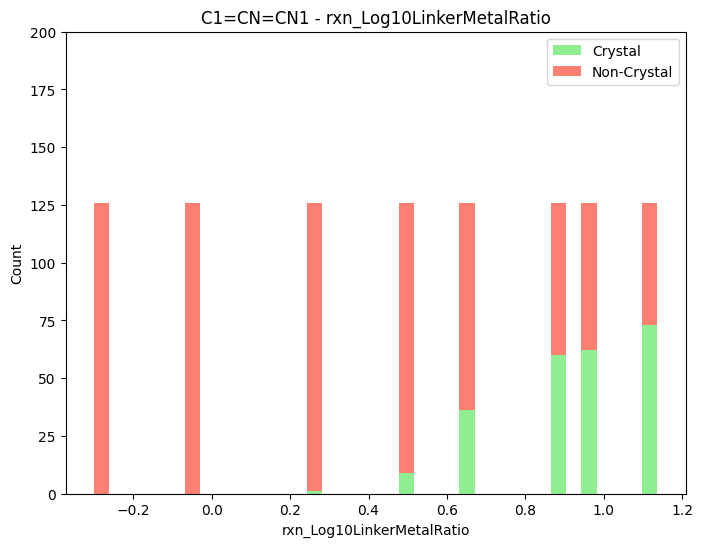

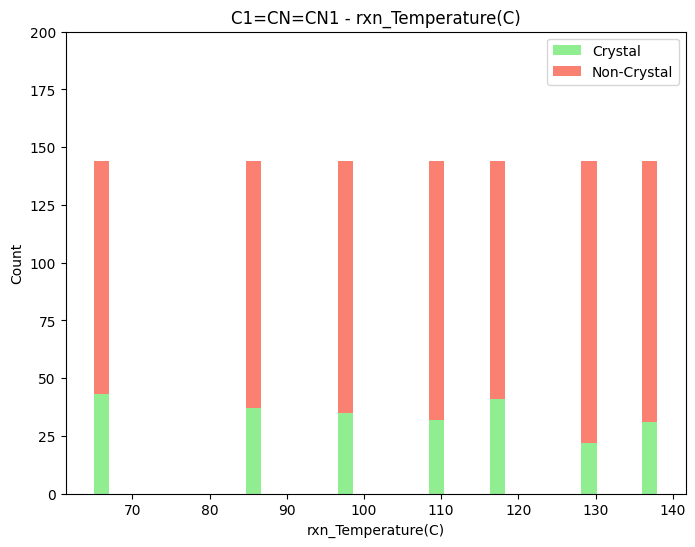

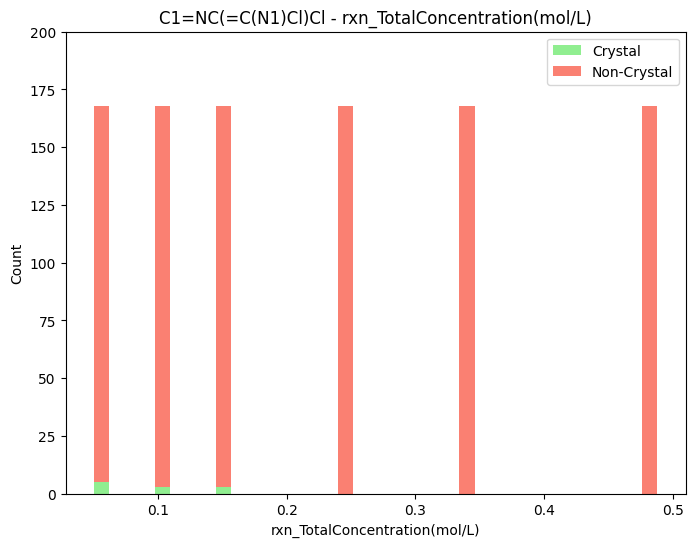

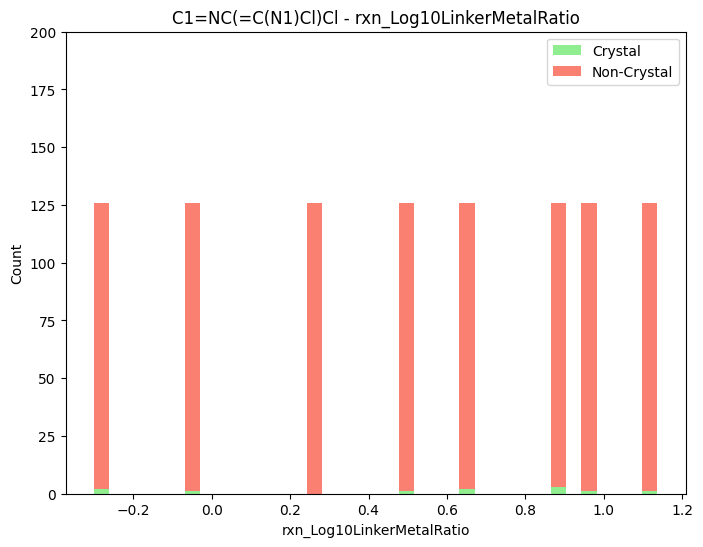

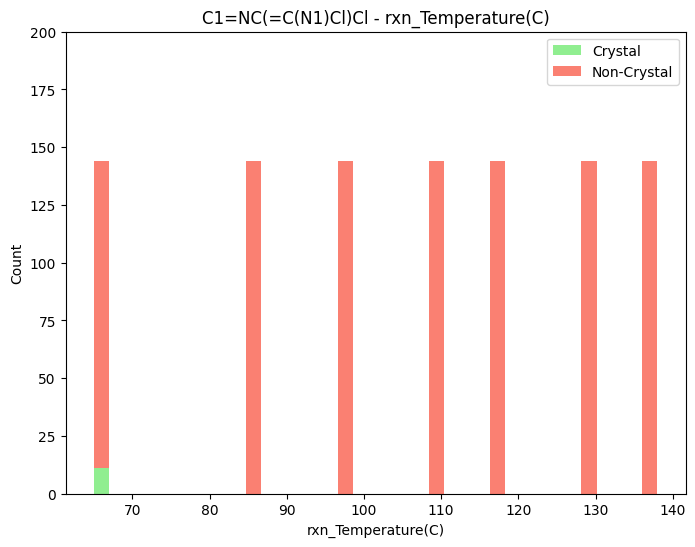

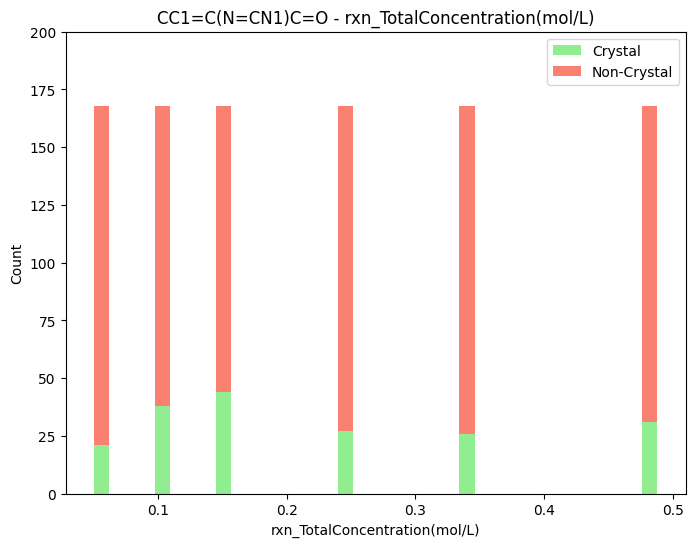

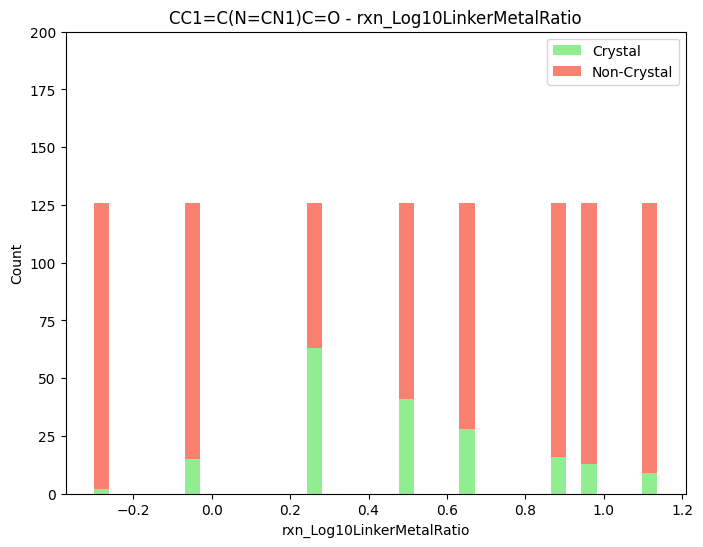

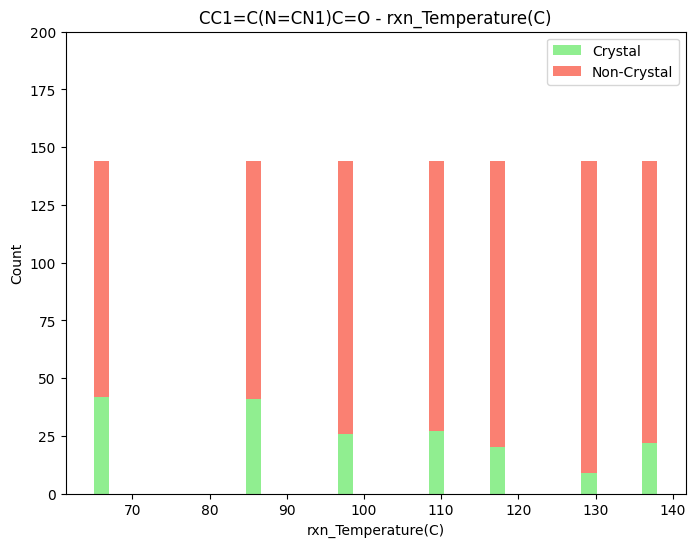

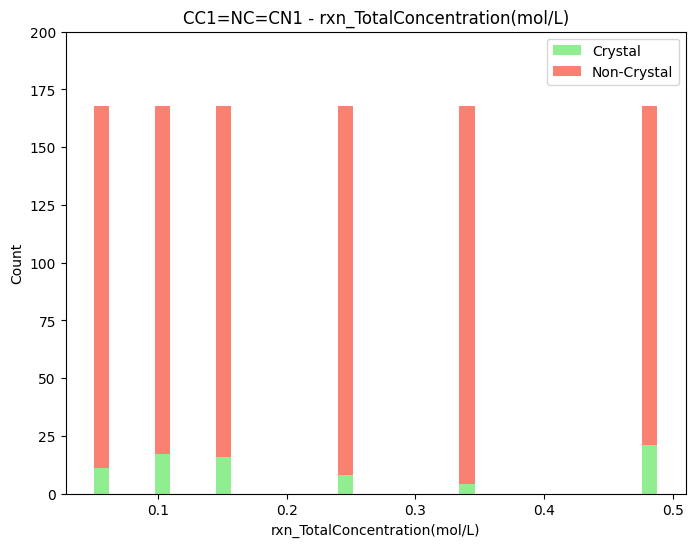

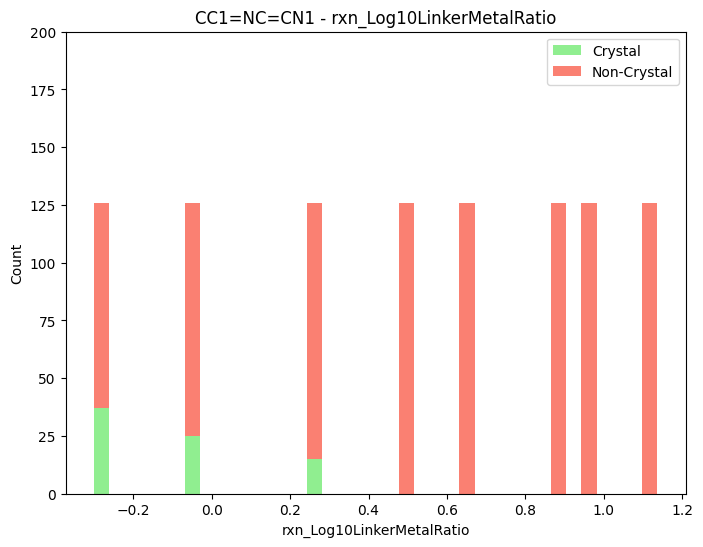

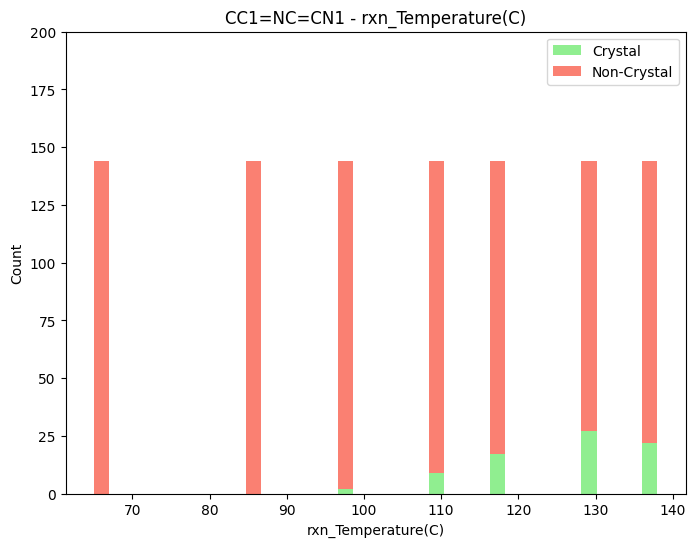

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_stacked_1d_histograms(df, linker_smiles, ranges, bins=20, bar_width_factor=0.8):
    # Filter DataFrame for specific linker smiles
    df_filtered = df[df['LinkerCanonicalSmiles'] == linker_smiles]

    # Parameters to plot
    parameters = ['rxn_TotalConcentration(mol/L)', 'rxn_Log10LinkerMetalRatio', 'rxn_Temperature(C)']

    for col in parameters:
        # Prepare data for crystal and non-crystal outcomes
        crystal_data = df_filtered[df_filtered['Crystal_clf'] == 1][col]
        non_crystal_data = df_filtered[df_filtered['Crystal_clf'] == 0][col]

        plt.figure(figsize=(8, 6))

        # Create bins
        bins_range = np.linspace(ranges[col][0], ranges[col][1], bins)

        # Count crystal and non-crystal data in each bin
        crystal_counts, _ = np.histogram(crystal_data, bins=bins_range)
        non_crystal_counts, _ = np.histogram(non_crystal_data, bins=bins_range)

        # Stacked bar plot
        plt.bar(bins_range[:-1], crystal_counts, width=np.diff(bins_range)*bar_width_factor, align='edge', 
                color='lightgreen', label='Crystal')
        plt.bar(bins_range[:-1], non_crystal_counts, bottom=crystal_counts, width=np.diff(bins_range)*bar_width_factor, 
                align='edge', color='salmon', label='Non-Crystal')

        plt.xlabel(col)
        plt.ylabel('Count')
        plt.title(f'{linker_smiles} - {col}')
        plt.ylim(0, 200)  # Set y-axis range to 0-200
        plt.legend()
        plt.grid(False)  # Disable the grid
        plt.show()

# Load the dataset
file_path = r"C:\Users\iabdu\Downloads\ZIF_ML_Figures\8Kdataset_FinalizedFeatures.csv"
df = pd.read_csv(file_path)

# Determine the range for each parameter
parameters = ['rxn_TotalConcentration(mol/L)', 'rxn_Log10LinkerMetalRatio', 'rxn_Temperature(C)']
ranges = {param: (df[param].min(), df[param].max()) for param in parameters}

# Iterate over each unique linker canonical smiles and plot
for linker_smiles in np.unique(df['LinkerCanonicalSmiles'].values):
    plot_stacked_1d_histograms(df, linker_smiles, ranges, bar_width_factor=0.5)  # Adjust bar width factor as needed


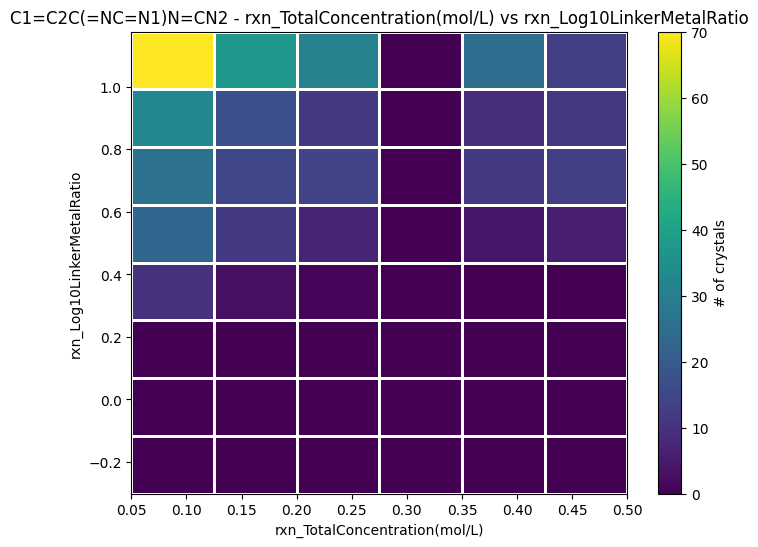

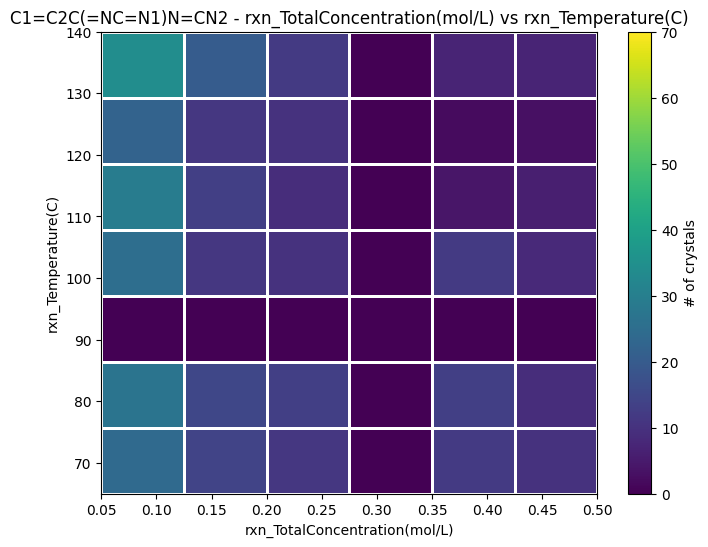

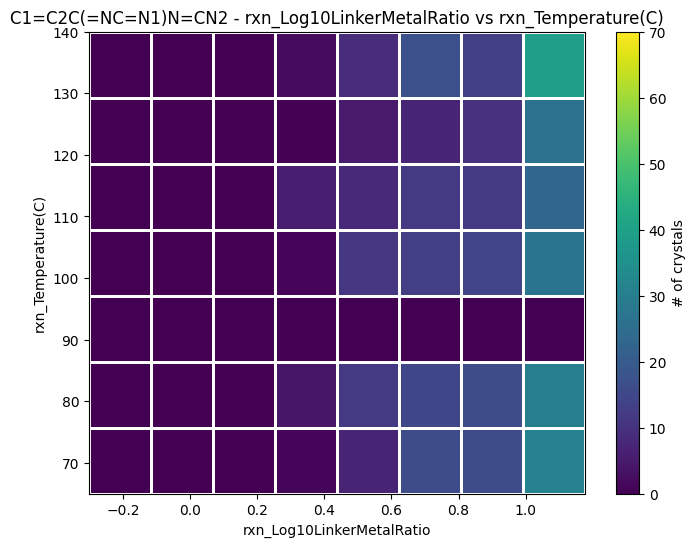

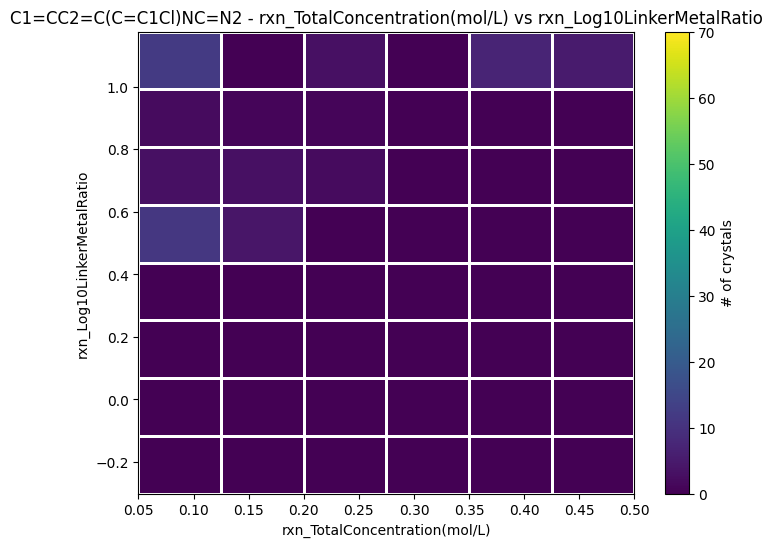

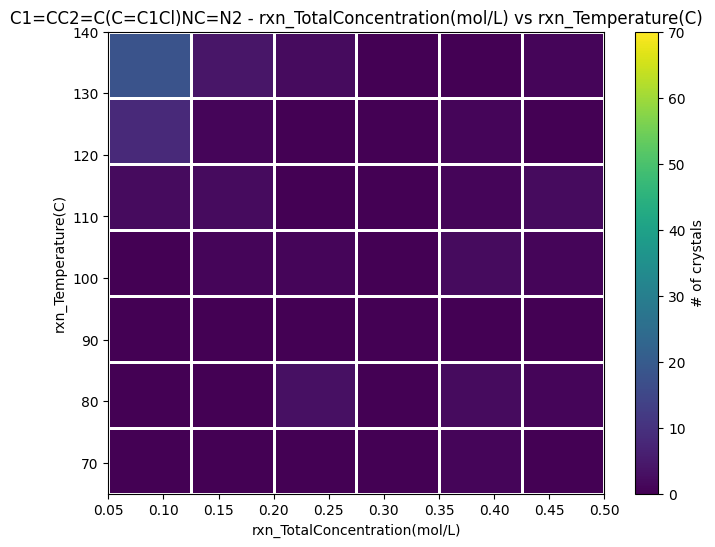

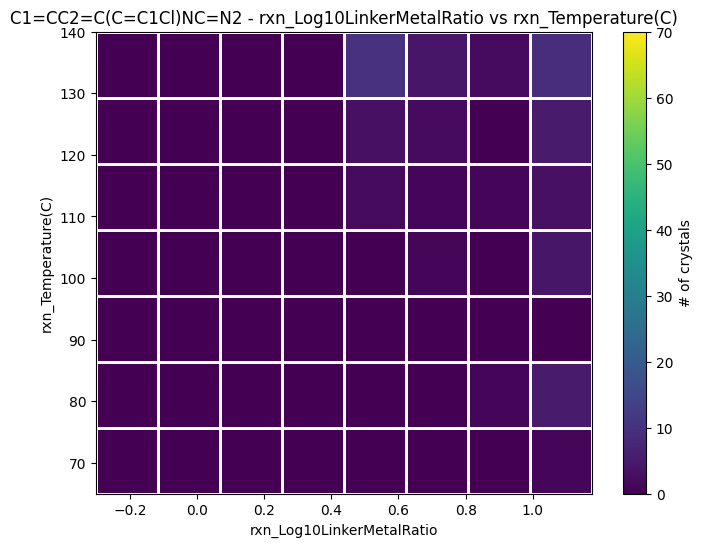

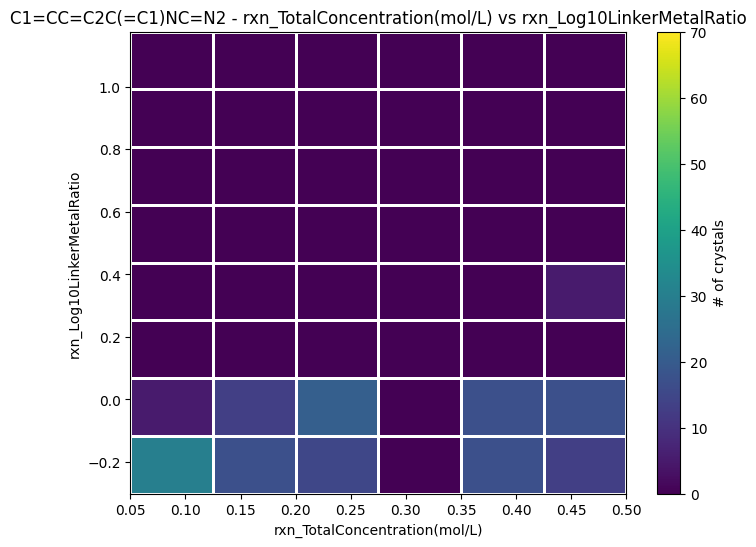

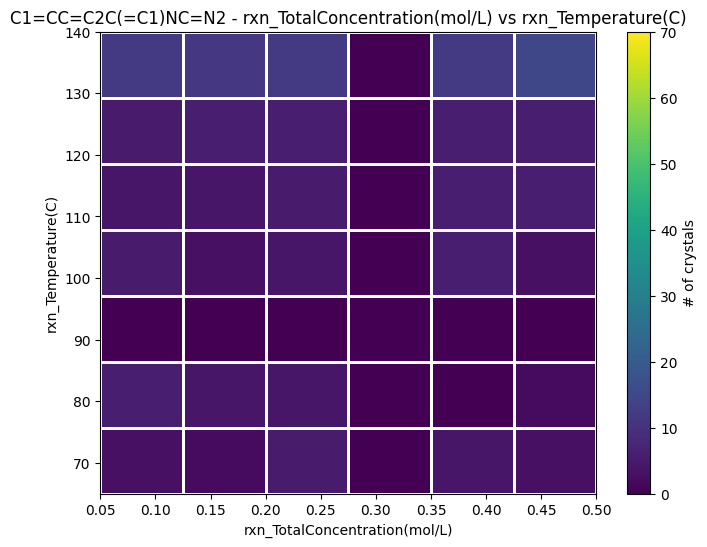

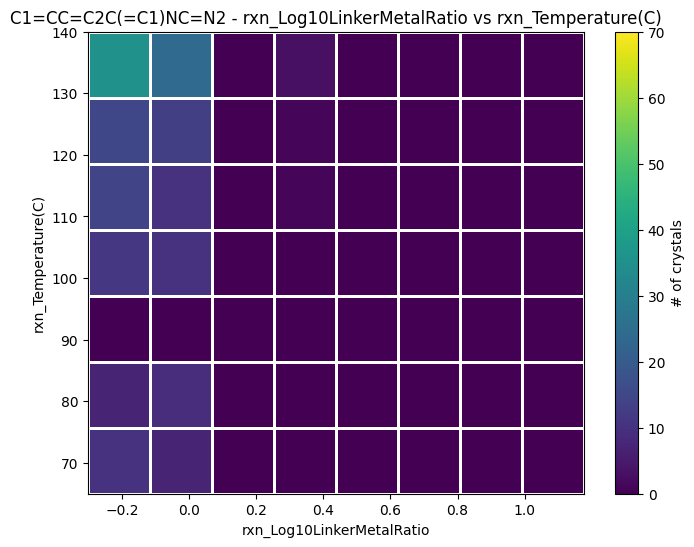

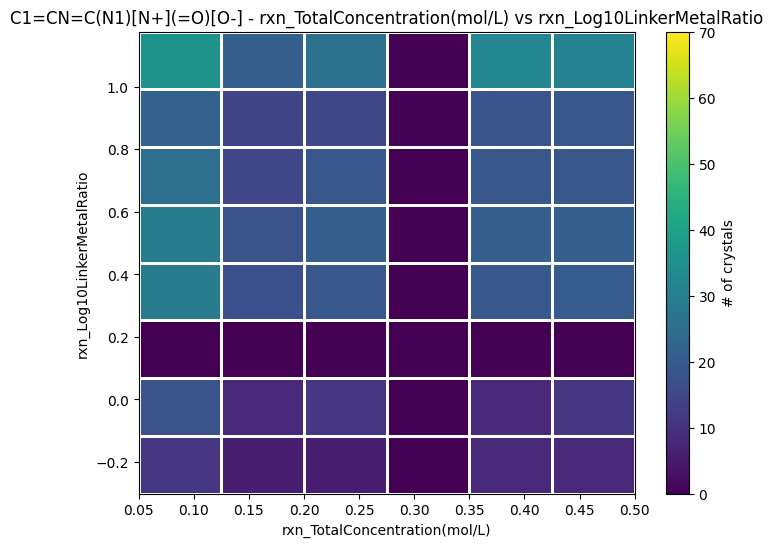

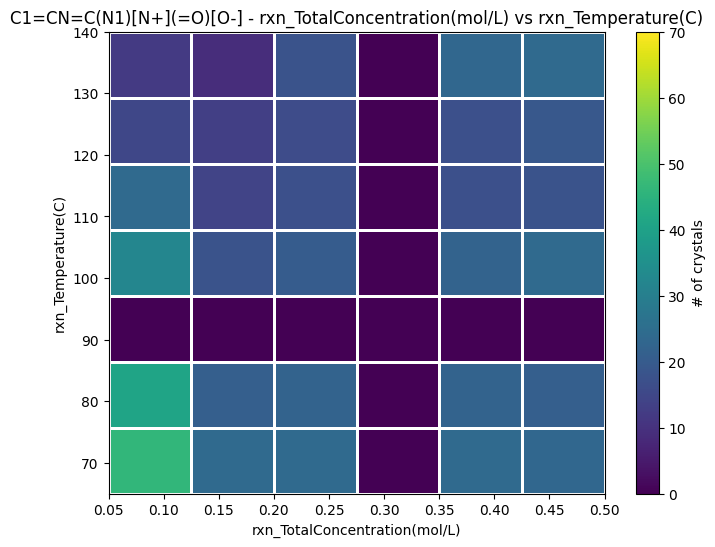

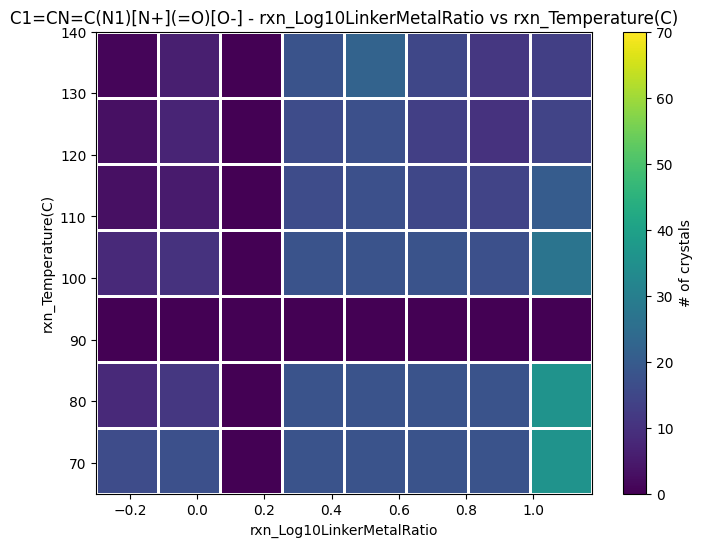

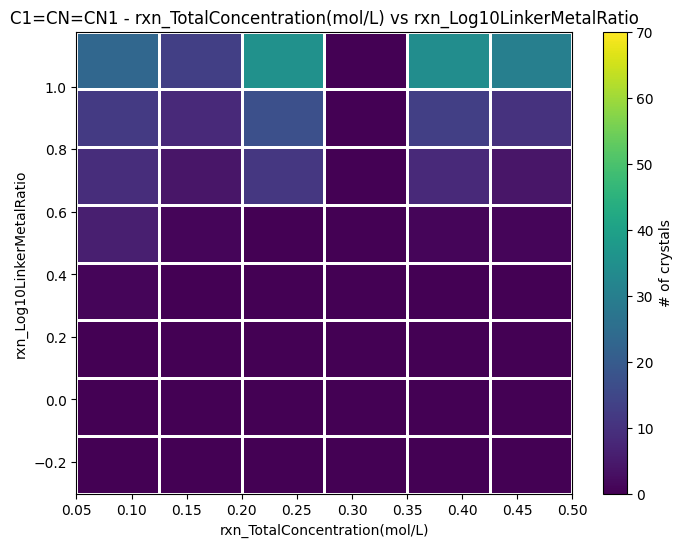

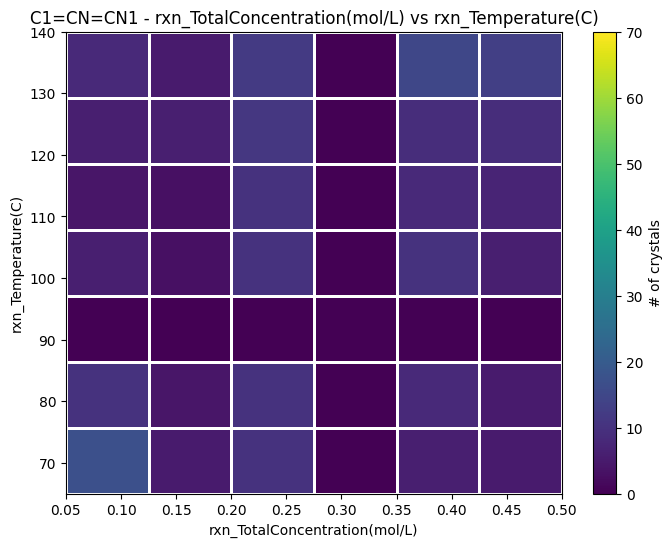

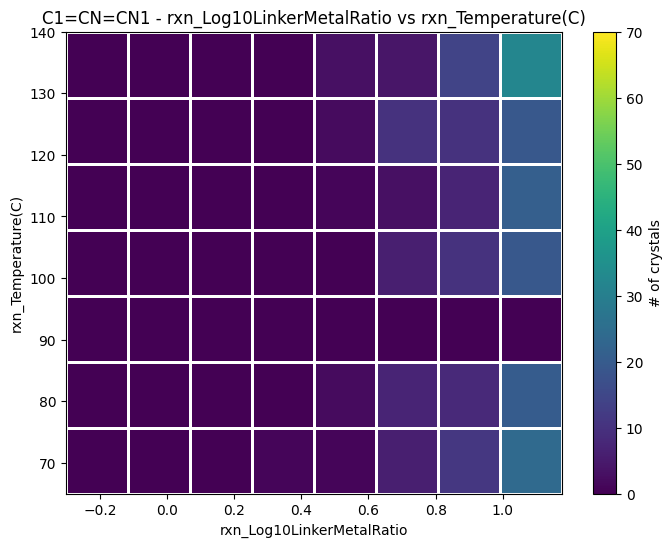

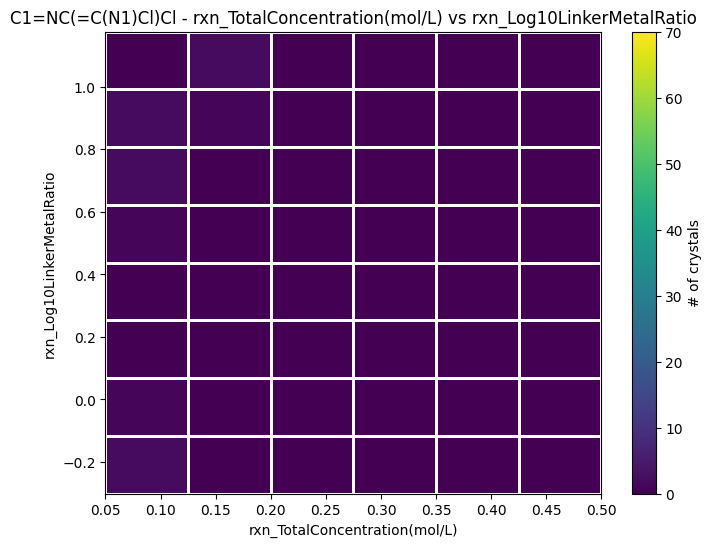

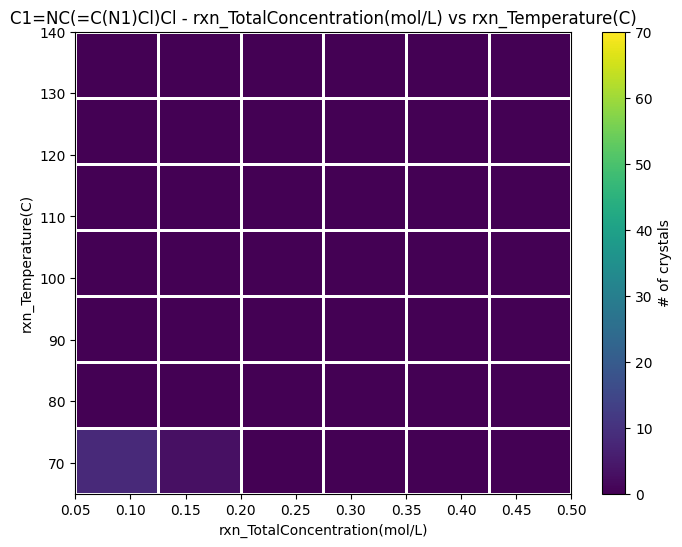

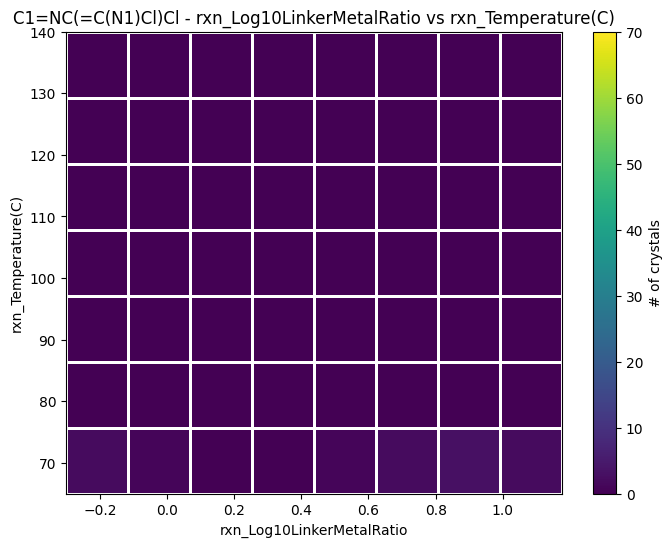

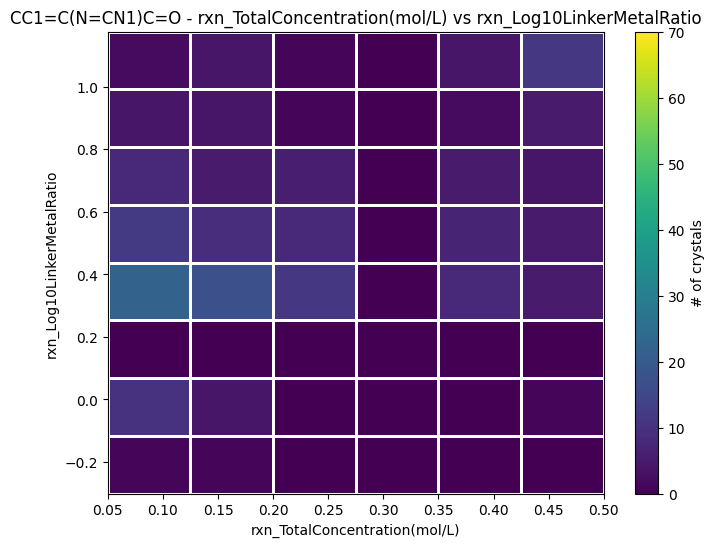

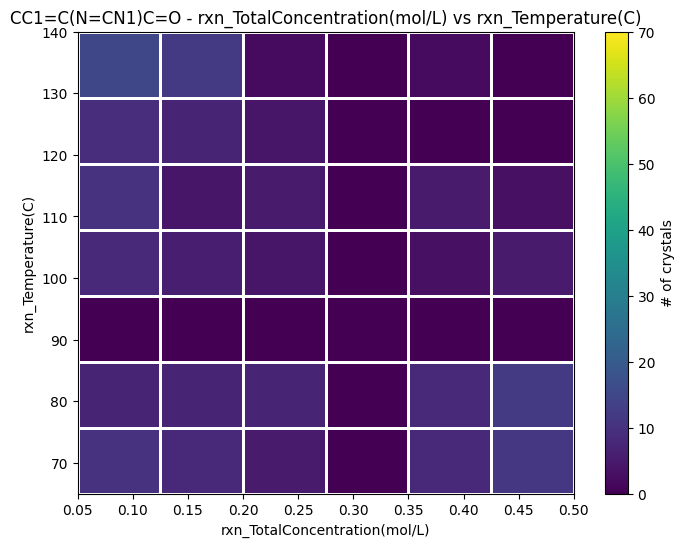

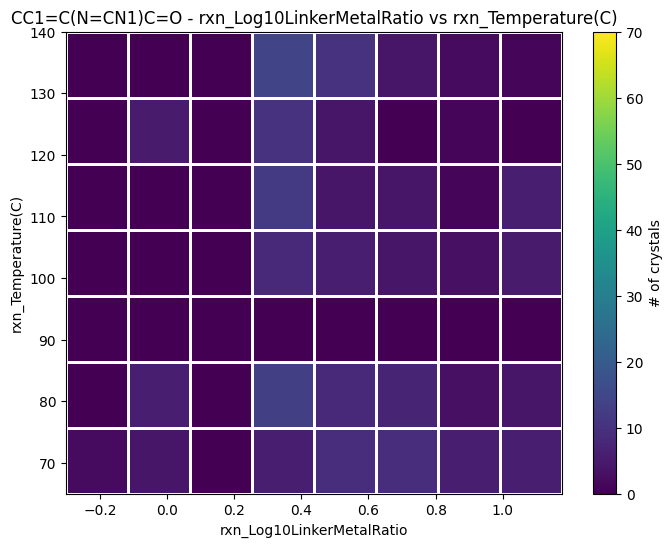

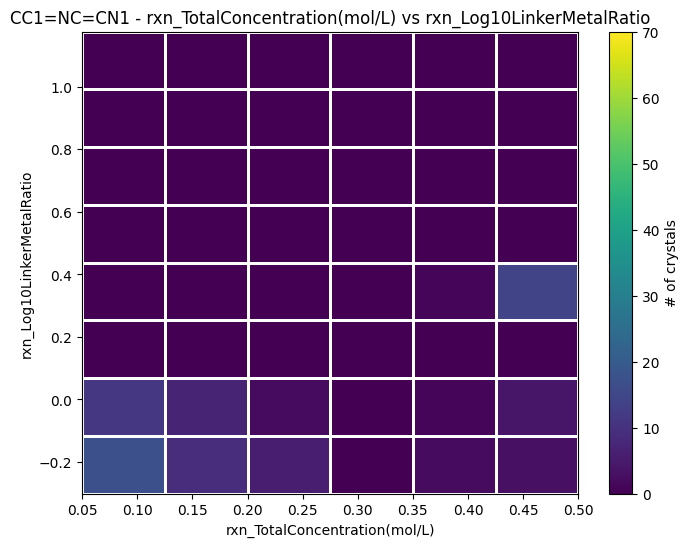

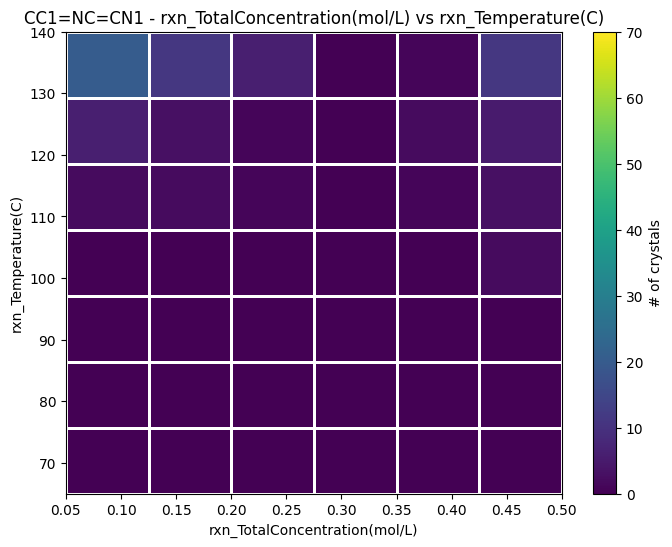

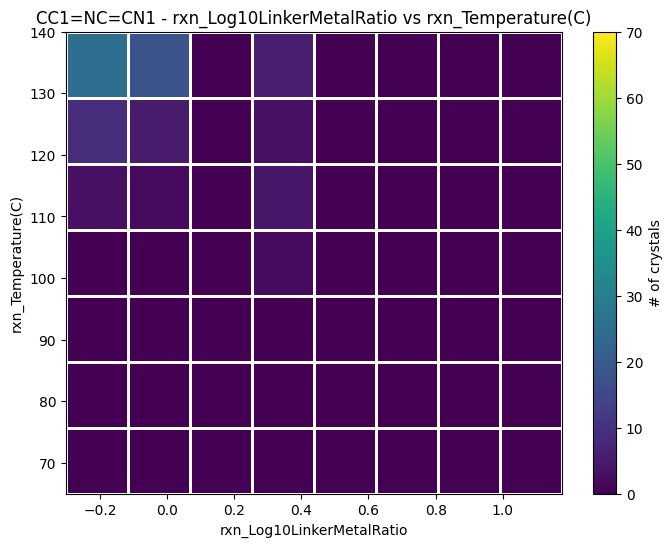

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_heat_maps(df, linker_smiles, axes_ranges, norm):
    # Filter DataFrame for specific linker smiles
    df_filtered = df[df['LinkerCanonicalSmiles'] == linker_smiles]

    # Define pairs for 2D heat maps
    pairs = [('rxn_TotalConcentration(mol/L)', 'rxn_Log10LinkerMetalRatio'),
             ('rxn_TotalConcentration(mol/L)', 'rxn_Temperature(C)'),
             ('rxn_Log10LinkerMetalRatio', 'rxn_Temperature(C)')]

    for x, y in pairs:
        plt.figure(figsize=(8, 6))
        x_range = axes_ranges[x]
        y_range = axes_ranges[y]

        # Calculate the number of bins as the product of the number of unique values for each parameter
        bins_x = len(df[x].unique())
        bins_y = len(df[y].unique())
        bins = (bins_x, bins_y)

        # Plot unsuccessful data points
        df_unsuccessful = df_filtered[df_filtered['Crystal_clf'] == 0]
        plt.hist2d(df_unsuccessful[x], df_unsuccessful[y], bins=bins, 
                   range=[x_range, y_range], cmap="gray", norm=norm, alpha=0.5)

        # Plot successful data points on top
        df_successful = df_filtered[df_filtered['Crystal_clf'] == 1]
        plt.hist2d(df_successful[x], df_successful[y], bins=bins, 
                   range=[x_range, y_range], cmap="viridis", norm=norm, edgecolor='white')

        plt.colorbar(label='# of crystals')
        plt.xlabel(x)
        plt.ylabel(y)
        plt.title(f'{linker_smiles} - {x} vs {y}')
        plt.xlim(x_range)
        plt.ylim(y_range)
        plt.grid(False)
        plt.show()

# Load the dataset
file_path = r"C:\Users\iabdu\Downloads\ZIF_ML_Figures\8Kdataset_FinalizedFeatures.csv"
df = pd.read_csv(file_path)

# Define axes ranges for each parameter
axes_ranges = {
    'rxn_TotalConcentration(mol/L)': (df['rxn_TotalConcentration(mol/L)'].min(), df['rxn_TotalConcentration(mol/L)'].max()),
    'rxn_Log10LinkerMetalRatio': (df['rxn_Log10LinkerMetalRatio'].min(), df['rxn_Log10LinkerMetalRatio'].max()),
    'rxn_Temperature(C)': (df['rxn_Temperature(C)'].min(), df['rxn_Temperature(C)'].max())
}

# Determine the maximum density across all datasets for normalization
max_density = 0
pairs = [('rxn_TotalConcentration(mol/L)', 'rxn_Log10LinkerMetalRatio'),
         ('rxn_TotalConcentration(mol/L)', 'rxn_Temperature(C)'),
         ('rxn_Log10LinkerMetalRatio', 'rxn_Temperature(C)')]

for linker_smiles in np.unique(df['LinkerCanonicalSmiles'].values):
    df_success = df[(df['Crystal_clf'] == 1) & (df['LinkerCanonicalSmiles'] == linker_smiles)]
    for x, y in pairs:
        bins_x = len(df[x].unique())
        bins_y = len(df[y].unique())
        bins = (bins_x, bins_y)
        hist, xedges, yedges = np.histogram2d(df_success[x], df_success[y], 
                                              bins=bins, range=[axes_ranges[x], axes_ranges[y]])
        max_density = max(max_density, hist.max())

# Normalization for color intensity
norm = mcolors.Normalize(vmin=0, vmax=max_density)

# Iterate over each unique linker canonical smiles and plot
for linker_smiles in np.unique(df['LinkerCanonicalSmiles'].values):
    plot_heat_maps(df, linker_smiles, axes_ranges, norm)


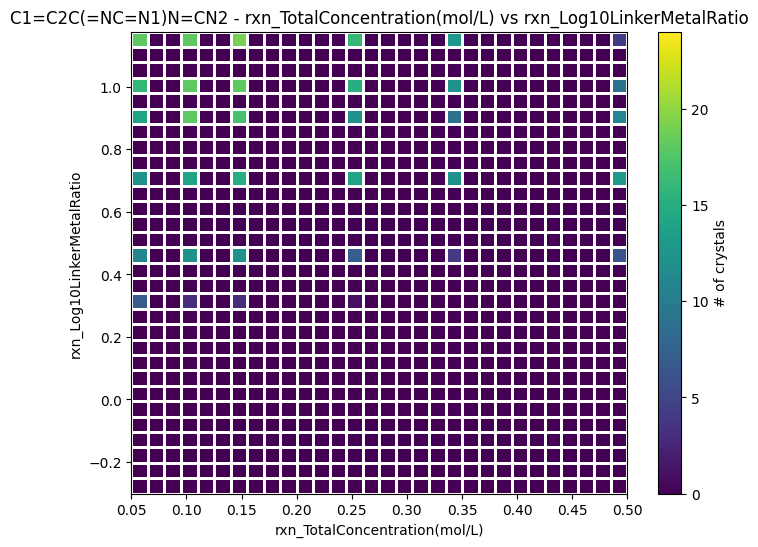

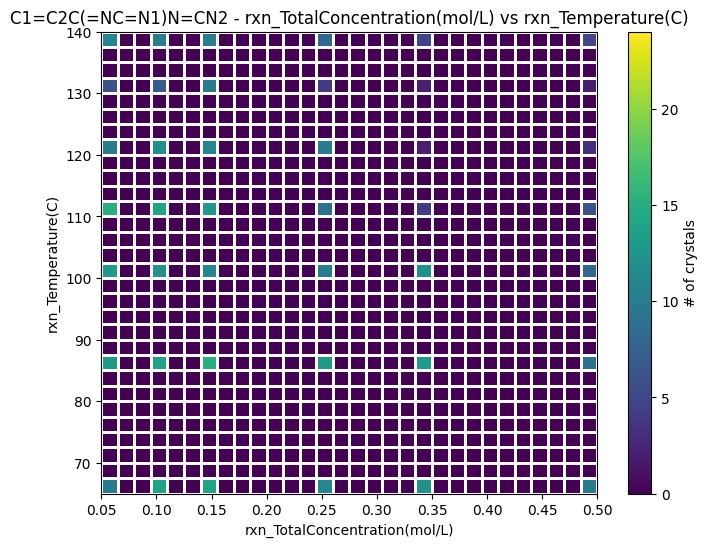

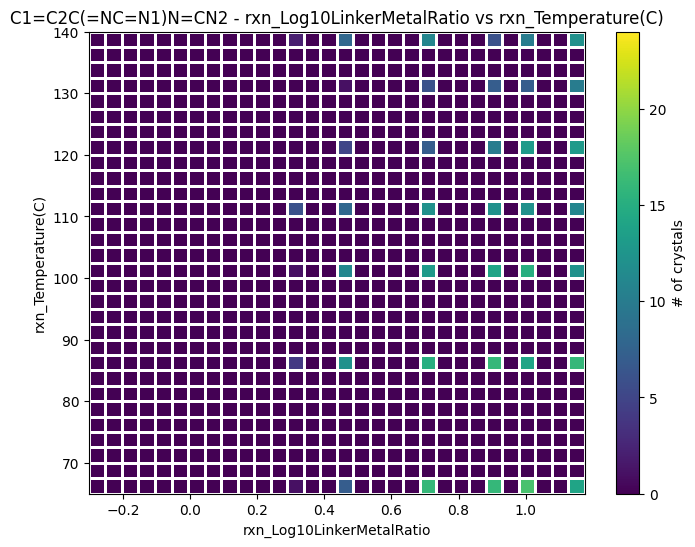

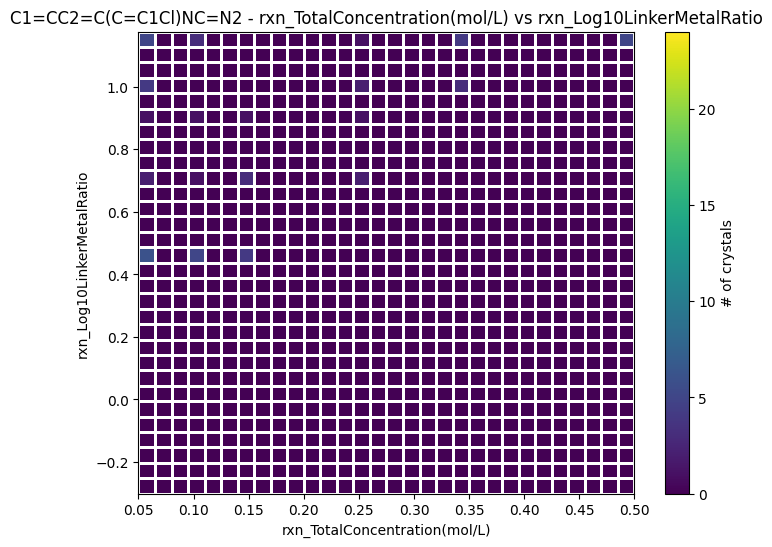

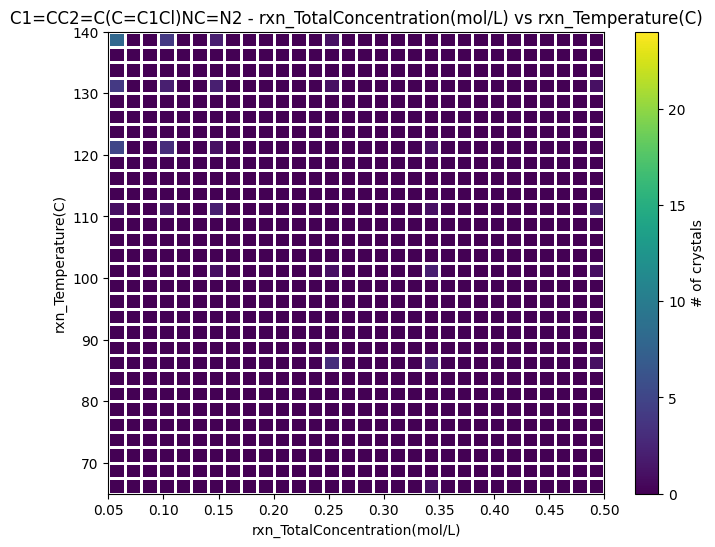

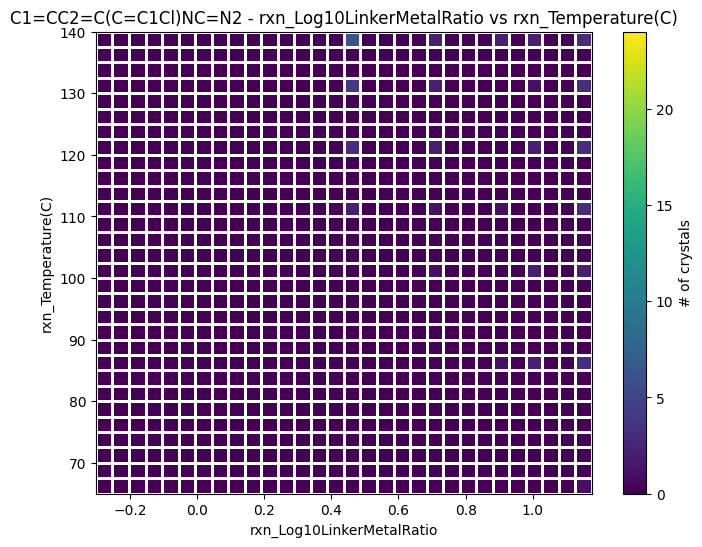

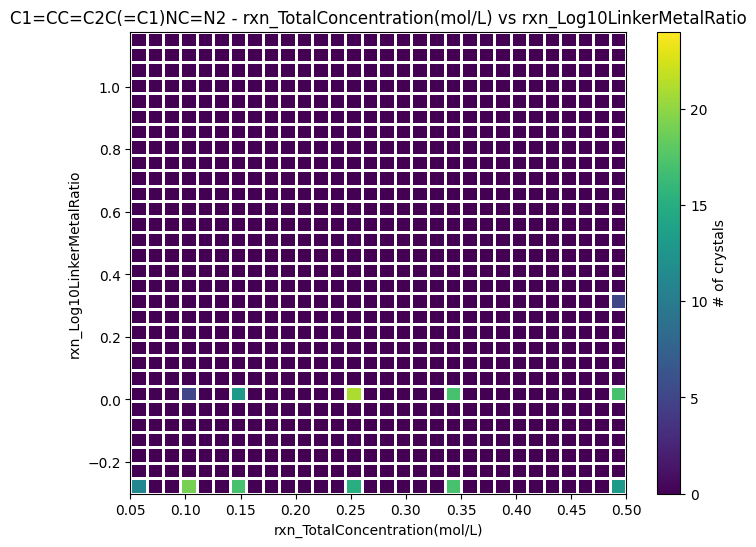

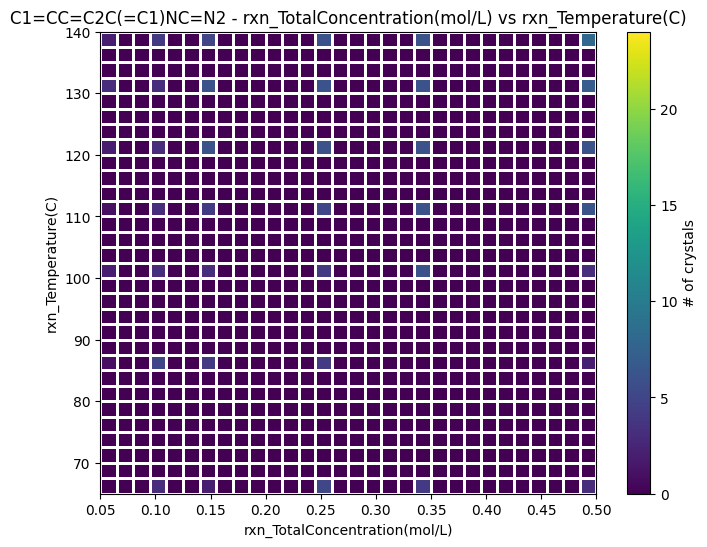

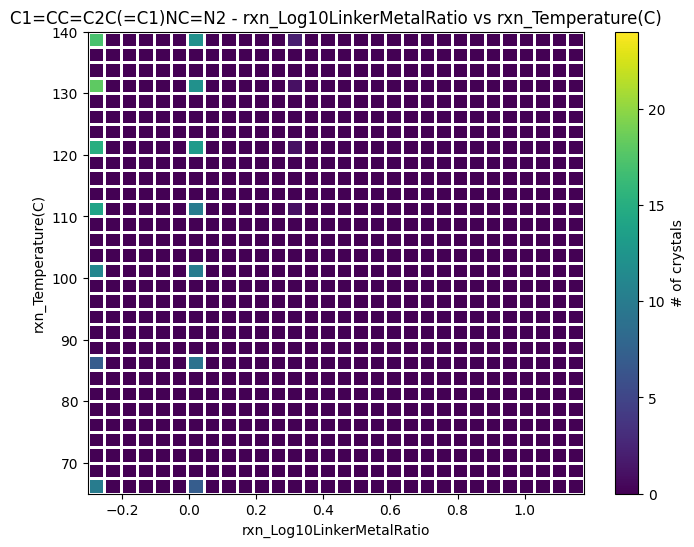

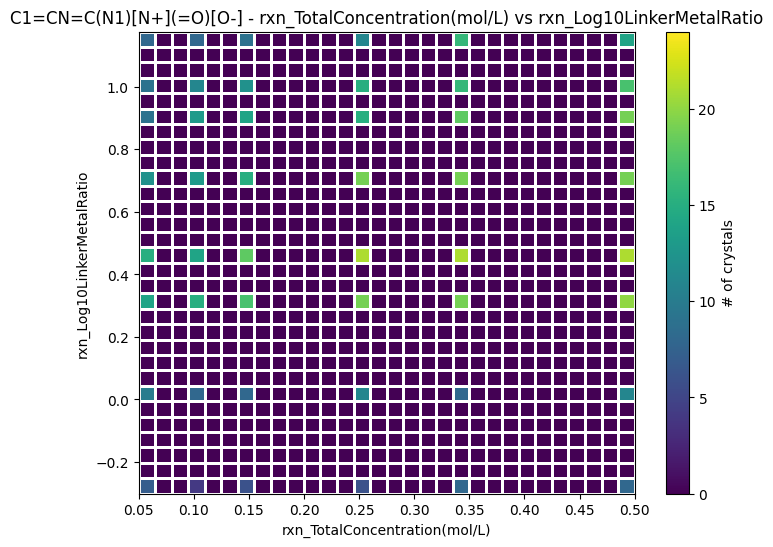

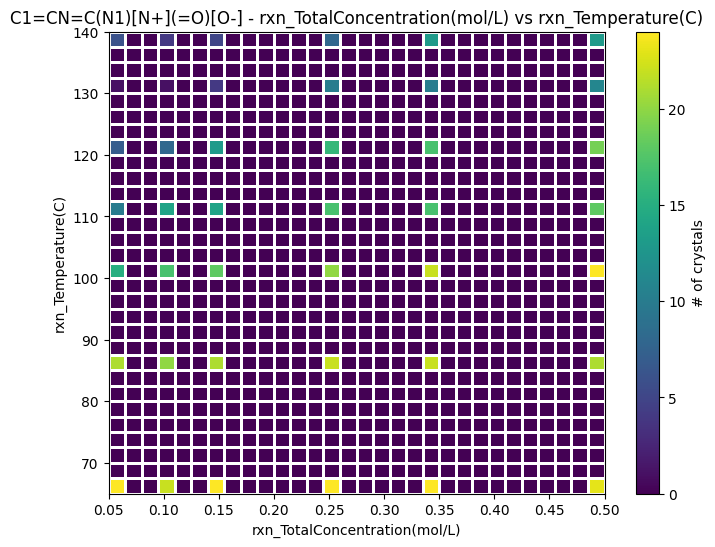

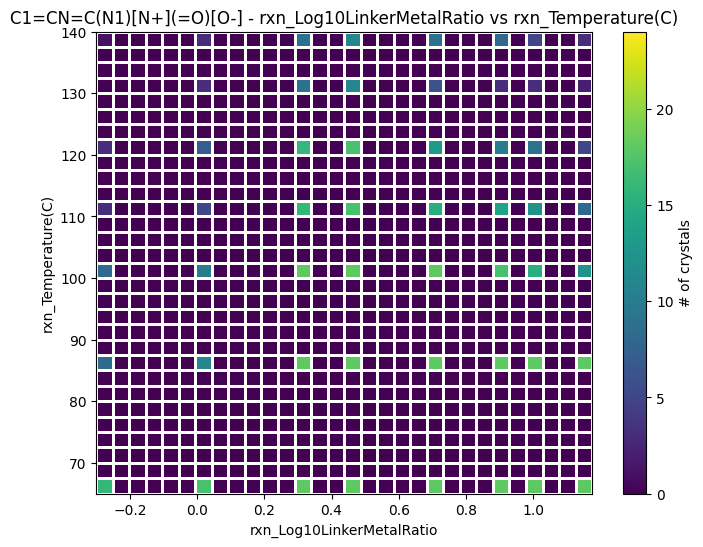

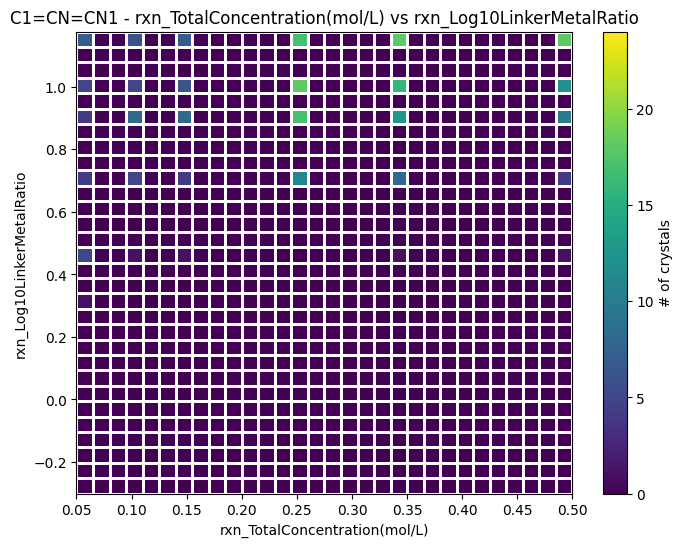

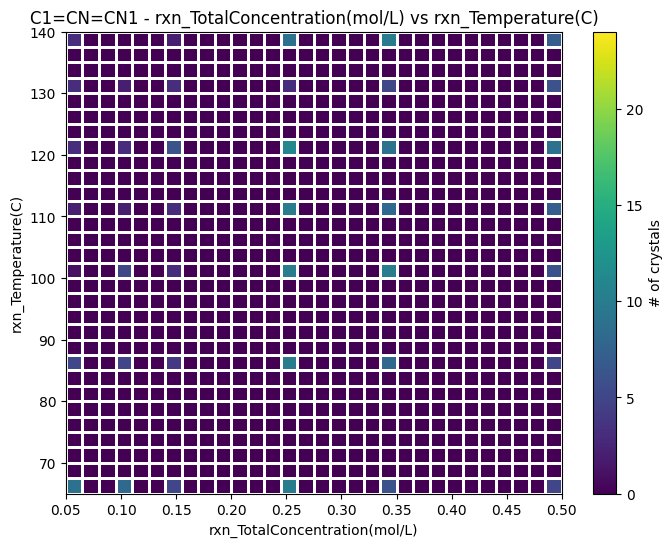

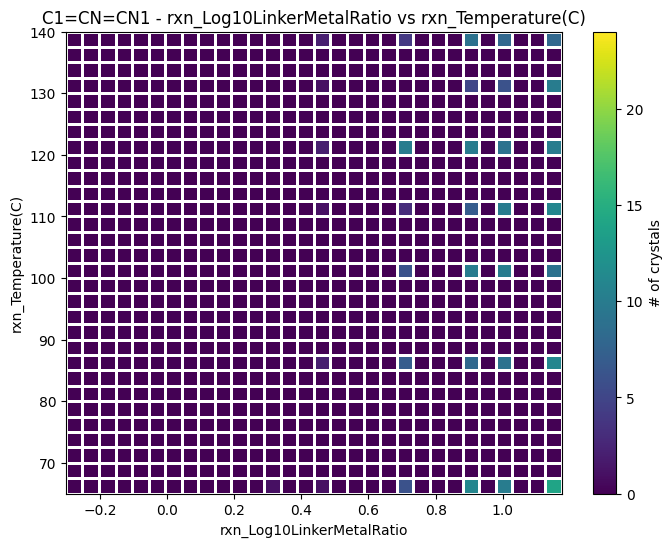

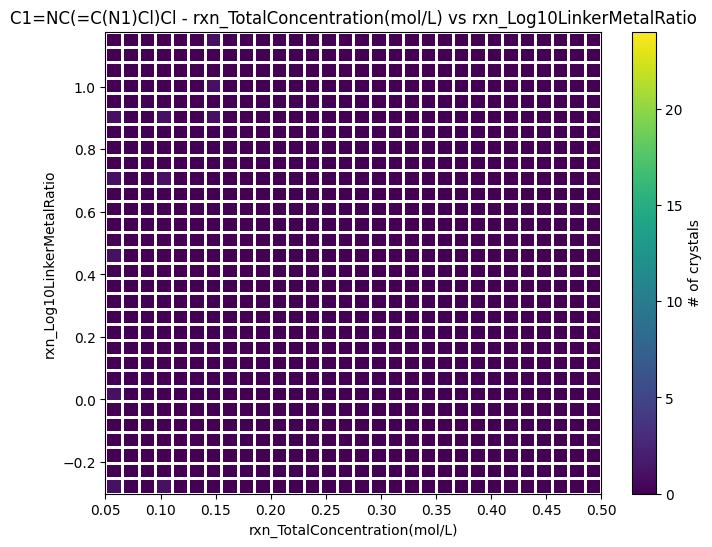

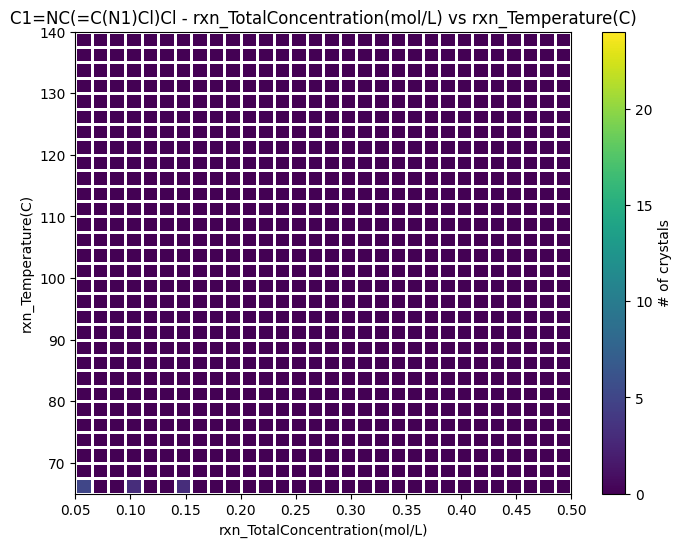

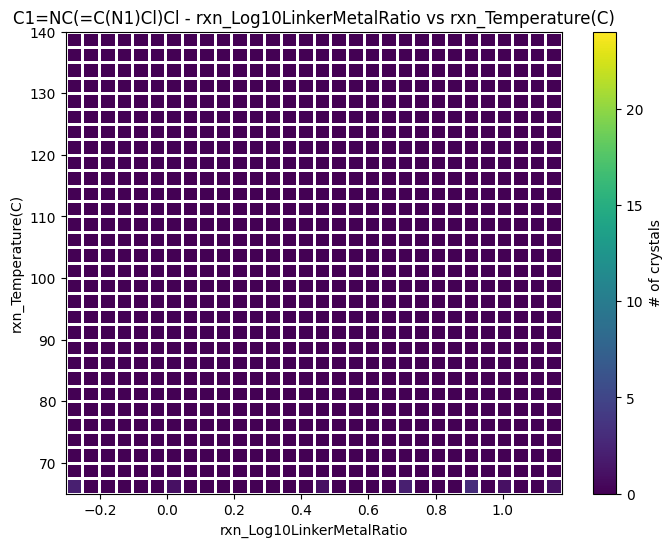

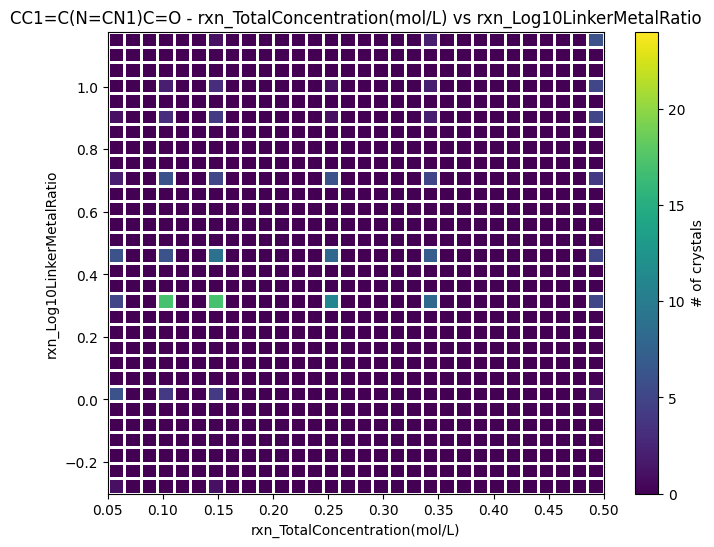

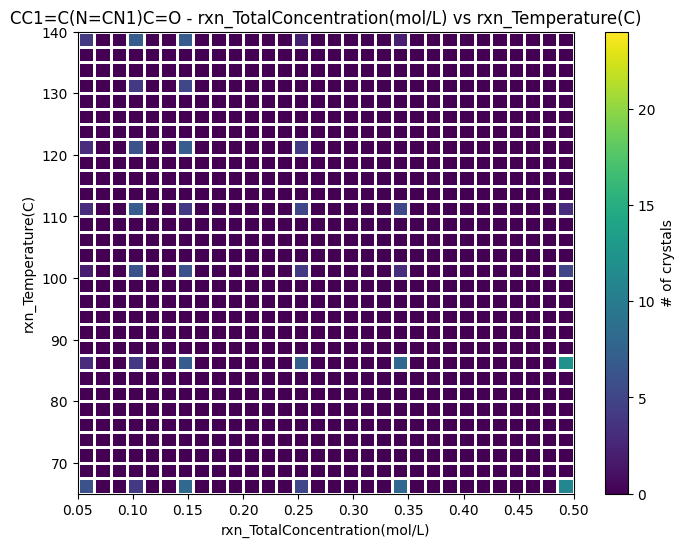

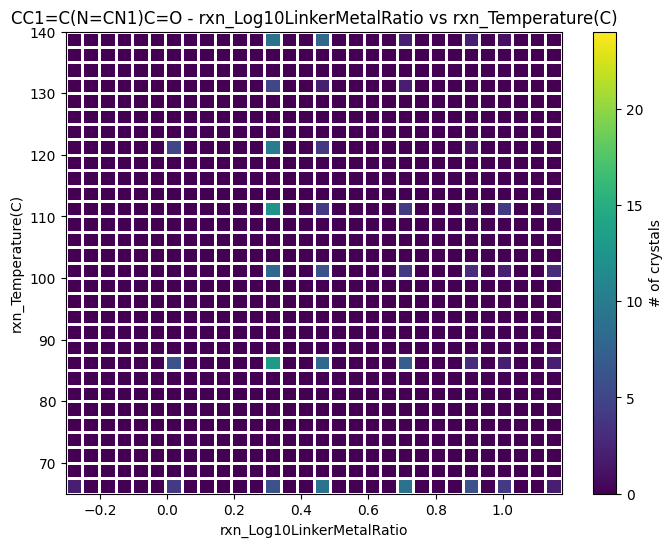

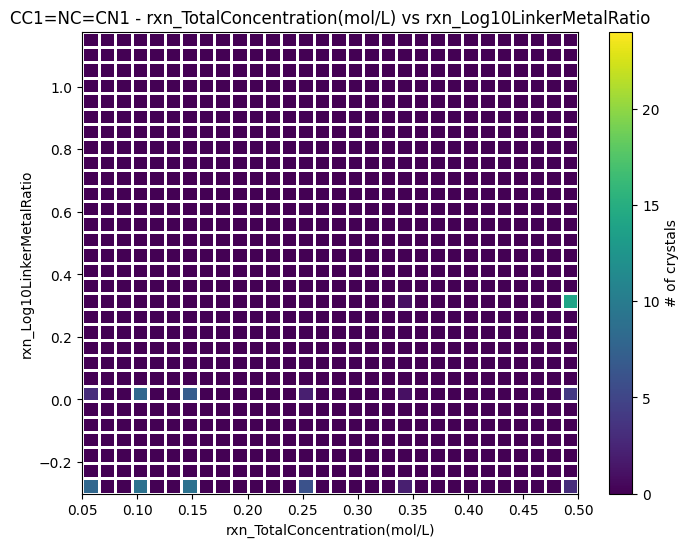

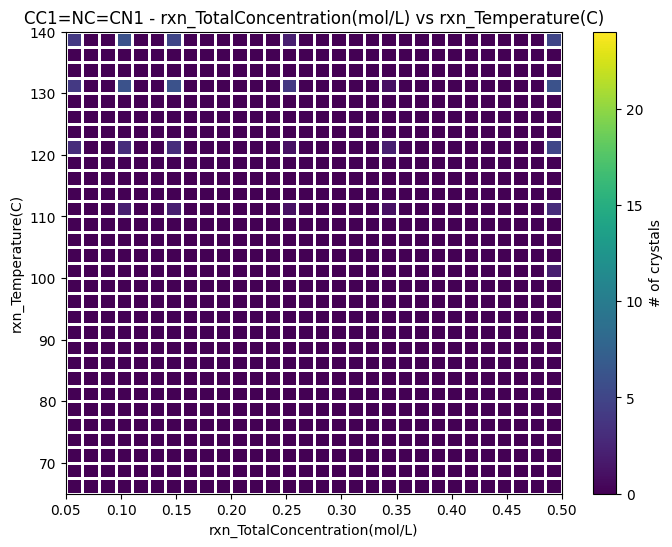

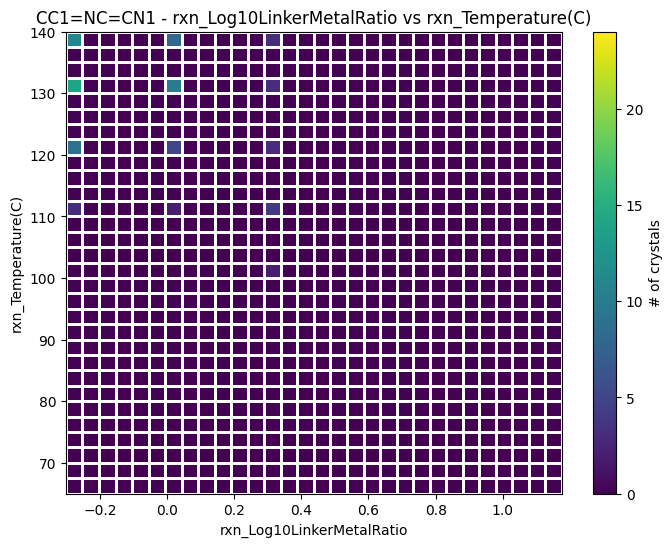

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_heat_maps(df, linker_smiles, axes_ranges, norm):
    # Filter DataFrame for specific linker smiles
    df_filtered = df[df['LinkerCanonicalSmiles'] == linker_smiles]

    # Define pairs for 2D heat maps
    pairs = [('rxn_TotalConcentration(mol/L)', 'rxn_Log10LinkerMetalRatio'),
             ('rxn_TotalConcentration(mol/L)', 'rxn_Temperature(C)'),
             ('rxn_Log10LinkerMetalRatio', 'rxn_Temperature(C)')]

    # Number of bins for the histogram
    bins = 30

    for x, y in pairs:
        plt.figure(figsize=(8, 6))
        x_range = axes_ranges[x]
        y_range = axes_ranges[y]

        # Plot unsuccessful data points
        df_unsuccessful = df_filtered[df_filtered['Crystal_clf'] == 0]
        plt.hist2d(df_unsuccessful[x], df_unsuccessful[y], bins=bins, 
                   range=[x_range, y_range], cmap="gray", norm=norm, alpha=0.5)

        # Plot successful data points on top
        df_successful = df_filtered[df_filtered['Crystal_clf'] == 1]
        plt.hist2d(df_successful[x], df_successful[y], bins=bins, 
                   range=[x_range, y_range], cmap="viridis", norm=norm, edgecolor='white')

        plt.colorbar(label='# of crystals')
        plt.xlabel(x)
        plt.ylabel(y)
        plt.title(f'{linker_smiles} - {x} vs {y}')
        plt.xlim(x_range)
        plt.ylim(y_range)
        plt.grid(False)
        plt.show()
        
# Load the dataset
file_path = r"C:\Users\iabdu\Downloads\ZIF_ML_Figures\8Kdataset_FinalizedFeatures.csv"
df = pd.read_csv(file_path)

# Define axes ranges for each parameter
axes_ranges = {
    'rxn_TotalConcentration(mol/L)': (df['rxn_TotalConcentration(mol/L)'].min(), df['rxn_TotalConcentration(mol/L)'].max()),
    'rxn_Log10LinkerMetalRatio': (df['rxn_Log10LinkerMetalRatio'].min(), df['rxn_Log10LinkerMetalRatio'].max()),
    'rxn_Temperature(C)': (df['rxn_Temperature(C)'].min(), df['rxn_Temperature(C)'].max())
}

# Determine the maximum density across all datasets for normalization
max_density = 0
pairs = [('rxn_TotalConcentration(mol/L)', 'rxn_Log10LinkerMetalRatio'),
         ('rxn_TotalConcentration(mol/L)', 'rxn_Temperature(C)'),
         ('rxn_Log10LinkerMetalRatio', 'rxn_Temperature(C)')]

for linker_smiles in np.unique(df['LinkerCanonicalSmiles'].values):
    df_success = df[(df['Crystal_clf'] == 1) & (df['LinkerCanonicalSmiles'] == linker_smiles)]
    for x, y in pairs:
        hist, xedges, yedges = np.histogram2d(df_success[x], df_success[y], 
                                              bins=30, range=[axes_ranges[x], axes_ranges[y]])
        max_density = max(max_density, hist.max())

# Normalization for color intensity
norm = mcolors.Normalize(vmin=0, vmax=max_density)

# Iterate over each unique linker canonical smiles and plot
for linker_smiles in np.unique(df['LinkerCanonicalSmiles'].values):
    plot_heat_maps(df, linker_smiles, axes_ranges, norm)
